In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps
import scipy.integrate as spint
import pandas as pd
from astropy.io import fits
import lmfit
from lmfit import Minimizer, Parameters, report_fit
import scipy.interpolate as spinterp
from astropy import units as u
import emcee
import corner
from multiprocess import Pool

<h1>Set Up</h1>
Loading the star data, grouping them by cluster names. <br>
<i>Code provided in the assignment 1 handout.</i>

In [2]:
dr3stars = fits.open('../Data/gaiadr3_cluster_stars.fits')
dr3stars.info()
stars_raw = pd.DataFrame(dr3stars[1].data)

Filename: ../Data/gaiadr3_cluster_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  members.dat    1 TableHDU       331   1291929R x 56C   [A20, I4, I19, I1, F10.8, F12.8, F10.8, F12.8, F10.8, F12.8, E11.4, E11.4, F10.8, E11.4, F10.8, E11.4, F10.8, F11.8, F11.8, E11.4, E11.4, E11.4, E11.4, E11.4, E11.4, I2, F12.8, F10.7, F11.8, F10.8, F19.8, F16.8, F18.8, F17.8, F18.8, F17.8, F10.7, F10.7, F10.7, E11.4, E11.4, E11.4, E9.3, F12.8, F4.1, F6.1, F5.1, F11.7, F11.8, F6.1, F12.7, F13.8, F5.1, A13, I1, I1]   


In [3]:
stars_raw['Name'] = stars_raw['Name'].str.strip()
clcounts = stars_raw.groupby(['Name']).size().reset_index(name='count')

In [4]:
stars_raw.columns
stars_raw

,Name,ID,GaiaDR3,inrt,Prob,RAdeg,e_RAdeg,DEdeg,e_DEdeg,GLON,...,o_RVd,GRVSmag,e_GRVSmag,o_GRVSmag,Vbroad,e_Vbroad,o_Vbroad,VarFlag,NSS,RVS
0,1636-283,0,6032349260227596544,0,0.747692,249.708525,0.201080,-28.585117,0.115789,351.679705,...,0.0,0.00000,0.000000,0.0,0.00000,0.000000,0.0,NOT_AVAILABLE,0,0
1,1636-283,0,6032358331198284160,1,1.000000,249.866424,0.020684,-28.402037,0.013691,351.914287,...,8.0,0.00000,0.000000,0.0,0.00000,0.000000,0.0,NOT_AVAILABLE,0,0
2,1636-283,0,6032358331198285696,1,0.843798,249.865221,0.046356,-28.399406,0.029595,351.915643,...,0.0,0.00000,0.000000,0.0,0.00000,0.000000,0.0,NOT_AVAILABLE,0,0
3,1636-283,0,6032358331198286080,1,1.000000,249.861159,0.045101,-28.400698,0.030237,351.912273,...,0.0,0.00000,0.000000,0.0,0.00000,0.000000,0.0,NOT_AVAILABLE,0,0
4,1636-283,0,6032358670488486784,1,1.000000,249.939480,0.038724,-28.429366,0.023344,351.935370,...,0.0,0.00000,0.000000,0.0,0.00000,0.000000,0.0,NOT_AVAILABLE,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291924,vdBergh_92,7163,3045840104515988992,1,1.000000,106.116546,0.110176,-11.474387,0.111851,224.621323,...,0.0,0.00000,0.000000,0.0,0.00000,0.000000,0.0,NOT_AVAILABLE,0,0
1291925,vdBergh_92,7163,3045840074455065088,1,0.838193,106.136236,0.049847,-11.471452,0.049169,224.627544,...,0.0,0.00000,0.000000,0.0,0.00000,0.000000,0.0,NOT_AVAILABLE,0,0
1291926,vdBergh_92,7163,3045840074453671680,1,0.639341,106.135606,0.056229,-11.468653,0.058581,224.624770,...,0.0,0.00000,0.000000,0.0,0.00000,0.000000,0.0,VARIABLE,0,0
1291927,vdBergh_92,7163,3045840654267074048,1,0.738133,106.159649,0.058318,-11.436082,0.062037,224.606570,...,0.0,0.00000,0.000000,0.0,0.00000,0.000000,0.0,NOT_AVAILABLE,0,0


I will be working with the clusters FSR_0496, NGC_2671 and NGC_7086. Let us reduce our dataset to just these.

In [5]:
cluster_names = ['FSR_0496', 'NGC_2671', 'NGC_7086']
stars = stars_raw[(stars_raw['Name'] == cluster_names[0]) | (stars_raw['Name'] == cluster_names[1]) | (stars_raw['Name'] == cluster_names[2])]
stars

,Name,ID,GaiaDR3,inrt,Prob,RAdeg,e_RAdeg,DEdeg,e_DEdeg,GLON,...,o_RVd,GRVSmag,e_GRVSmag,o_GRVSmag,Vbroad,e_Vbroad,o_Vbroad,VarFlag,NSS,RVS
149190,FSR_0496,1536,431106934322351104,1,0.896053,6.703433,0.026897,63.949958,0.031286,120.232055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0
149191,FSR_0496,1536,431152735855187328,1,1.000000,6.203185,0.026594,64.003094,0.026734,120.018890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0
149192,FSR_0496,1536,431152598416247168,1,0.948556,6.195106,0.021414,63.974166,0.020642,120.012377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0
149193,FSR_0496,1536,431152594111588224,1,0.933604,6.177108,0.092318,63.981790,0.095471,120.005311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0
149194,FSR_0496,1536,431152529696747136,1,0.816943,6.248152,0.049394,64.028645,0.048575,120.041120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864363,NGC_7086,4846,2171702934225562624,1,0.961948,322.579819,0.040063,51.496390,0.037197,94.320878,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0
864364,NGC_7086,4846,2171702934225575936,0,0.445606,322.569747,0.053879,51.501449,0.050740,94.319771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0
864365,NGC_7086,4846,2171703488286248832,1,0.782017,322.634876,0.014393,51.546181,0.014287,94.379931,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0
864366,NGC_7086,4846,2171680329822167552,1,0.780374,322.477507,0.020446,51.476934,0.020839,94.261138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0


<h1>Task 1</h1>

Defining a function that calculates the radial distance from the centre for each star in a given cluster:

In [6]:
def calc_rad_dist(cl_name, star_data):
    """
    Calculates the radial distance from the center for stars in a given cluster.
    Returns a dataframe of stars belonging to only the given cluster.
    """
    star_data_selected = star_data[(stars['Name'] == cl_name)]
    mean_RA = star_data_selected['RAdeg'].values.mean()
    mean_DE = star_data_selected['DEdeg'].values.mean()
    
    star_data_selected['rad_dist'] = 3600*np.sqrt((star_data_selected['RAdeg'] - mean_RA)**2 + (star_data_selected['DEdeg'] - mean_DE)**2)
    
    return star_data_selected

Let us define a function that can plot a density profile for a cluster given the radial distances. <br>
We calculate the stellar density by calculating the area of a given bin using:
$$
A = \pi (R_{outer}^2 - R_{inner}^2)
$$
where $R_{outer}$ is the radius of the outer edge of the bin and $R_{inner}$ is the radius of the inner edge of the bin. We can then calculate the density by dividing the counts in that bin by the are of that bin. <br>

We need to be careful how we bin the data though. For the central limit theorem to hold, we want ateast around 20 counts per bin, hence we take the function 'histrebin' from the online material to let us re-bin the data so that this condition is satisfied

In [7]:
# Below taken from online material
def histrebin(mininbin,counts,edges):
    '''
    Takes as input a minimum counts per bin and a histogram counts and bin edges, and combines 
       adjacent histogram bins as needed so that no bin has less than the required minimum.
       Inputs:
           mininbin - required minimum counts/bin.
           counts, edges - input histogram counts/bin and bin edges arrays.
       Outputs:
           counts2, edges2 - rebinned counts/bin and bin edges arrays
    '''
    edges2=np.zeros(1)
    counts2=np.zeros(1)
    i=0
    countsum=0
    firstbin_flag = 1
    edges2[0]=edges[0]
    for x in counts:
        countsum=countsum+x
        i=i+1
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):  # The sum over counts in 
            # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
            if firstbin_flag == 1: # if this is the first bin satisfying our requirement, 
                # do not append but replace bin 0 with countsum
                counts2[0]=countsum
                firstbin_flag = 0 # now we read the first bin we can switch this off
            else:
                counts2=np.append(counts2,countsum)
            edges2=np.append(edges2,edges[i])
            countsum=0        
    return counts2, edges2

def stellar_density(star_data, ret_counts=False):
    counts, edges = np.histogram(star_data['rad_dist'], bins=500)
    counts, edges = histrebin(20, counts, edges) # Rebinning data such that each bin has a minimum of 20 counts
    
    bin_centres = (edges[1:] + edges[:-1]) / 2
    bin_widths = np.diff(edges) 
    area = np.pi * (edges[1:]**2 - edges[:-1]**2)
    density = counts/area
    err_counts = np.sqrt(counts)/area
    if not ret_counts:
        return density, edges, err_counts, bin_widths
    else:
        return density, edges, err_counts, bin_widths, counts

We now call the stellar_density function on our dataset and plot the resulting stellar density profile. Note that the error bars along the x axis correspond to the bin widths and the ones along the y axis correspond to the error on the counts (this is just $\sqrt{n}/area$ as we scale down the poisson standard deviation by the same factor we scale down the counts).<br>
We do this in a for loop so that we can repeat it for all the clusters

C:\Users\shash\AppData\Local\Temp\ipykernel_27528\2198440143.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_data_selected['rad_dist'] = 3600*np.sqrt((star_data_selected['RAdeg'] - mean_RA)**2 + (star_data_selected['DEdeg'] - mean_DE)**2)


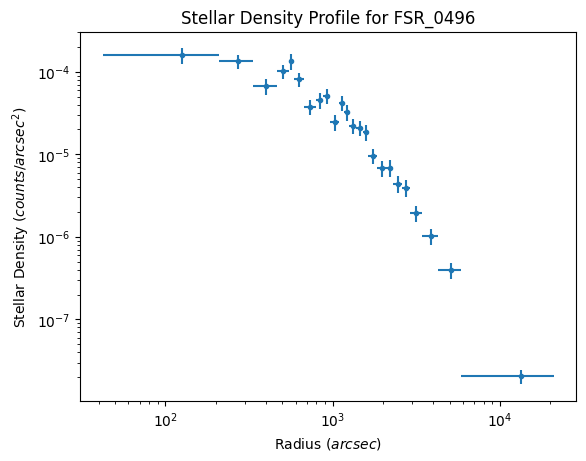

C:\Users\shash\AppData\Local\Temp\ipykernel_27528\2198440143.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_data_selected['rad_dist'] = 3600*np.sqrt((star_data_selected['RAdeg'] - mean_RA)**2 + (star_data_selected['DEdeg'] - mean_DE)**2)


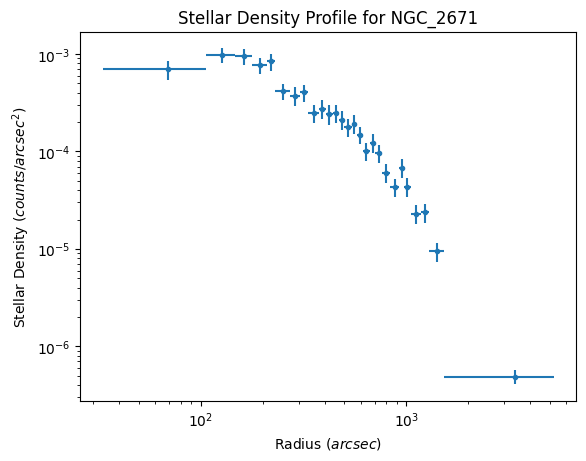

C:\Users\shash\AppData\Local\Temp\ipykernel_27528\2198440143.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_data_selected['rad_dist'] = 3600*np.sqrt((star_data_selected['RAdeg'] - mean_RA)**2 + (star_data_selected['DEdeg'] - mean_DE)**2)


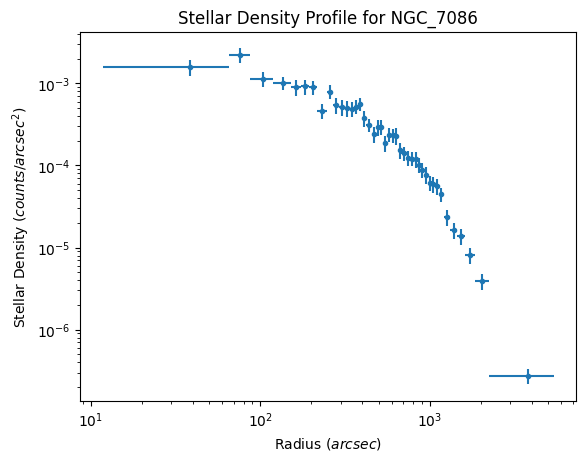

In [8]:
for i in range(len(cluster_names)):
    stars_updated = calc_rad_dist(cluster_names[i], stars)
    density, r_edges, err_counts, bin_widths = stellar_density(stars_updated)
    r_centers = (r_edges[1:] + r_edges[:-1]) / 2
    
    plt.errorbar(r_centers, density, xerr=bin_widths/2., yerr=err_counts, fmt='.', )
    
    plt.xlabel(f'Radius ($arcsec$)')
    plt.ylabel(f'Stellar Density ($counts/arcsec^2$)')
    plt.title(f'Stellar Density Profile for {cluster_names[i]}')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

<h2>Comments</h2>
The stellar density profiles look good. We can see that the hist-rebin has worked as the bin widths are not fixed anymore. There also seems to be enough data points for our analysis to be meaningful.

<h1>Task 2</h1>

The model that we want to fit to our data is the King Model. This gives us, for a given radius and other parameters, the number density of stars in the cluster. <br>
The model gives us the 'rate' of the counts for a given bin. If we assume that the rate is constant for that bin, we can get the number of counts in the bin predicted by the model by assuming that the counts are poisson distributed and integrating the distribution over the bin. We can take the function provided in the online material to do this, modifying it such that it integrates over the area of the bin rather than the width.

In [152]:
def model_bin(xbins, model, params):
    '''
    General function for integrating the input model over bins defined by contiguous (no gaps) 
        bin edges, xbins.
       Inputs:
           xbins - x bin edges.
           model, params - the model name and associated Parameters object.
       Outputs:
           ymod - calculated counts-density model values for y-axis.
    '''
    i = 0
    ymod = np.zeros(len(xbins)-1)
    for i, xval in enumerate(xbins[:-1]):
        # We need to integrate over the area of each bin rather than the radius
        ymod[i], ymoderr = spint.quad(lambda x: 2 * np.pi * x * model(x, params),xbins[i],xbins[i+1]) 
        ymod[i] = ymod[i]/(np.pi * (xbins[i+1]**2-xbins[i]**2))  # we now divide by the bin area to match the counts density
        # units of our data
    return ymod

We also need to define a function in such a way that we can conveniently use it with the lmfit package. Again, thankfully, this is provided in the online material :)

In [153]:
def lmf_hsq_binresid(params,xdata,ydata,yerrs,model,output_resid=True):
    '''
    lmfit objective function to calculate and return residual array or model y-values for
        binned data where the xdata are the input bin edges and ydata are the densities (integral over bin
        divided by bin width).
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata, yerrs - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y-value array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (residuals) is
                        required output, otherwise a list of model y-value arrays (corresponding to the 
                        input x-data list) is returned.
        Output: if output_resid==True, returns a residual array of (y_i-y_model(x_i))/yerr_i which is
            concatenated into a single array for all input data errors (i.e. length is n1+n2 in 
            the example above). If output_resid==False, returns a list of y-model arrays (one per input x-array)'''
    if output_resid == True:
        for i, xvals in enumerate(xdata):  # loop through each input dataset and record residual array
            if i == 0:
                resid = (ydata[i]-model_bin(xdata[i],model,params))/yerrs[i]
            else:
                resid = np.append(resid,(ydata[i]-model_bin(xdata[i],model,params))/yerrs[i])
        return resid
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin(xdata[i],model,params))
        return ymodel

Now we just need to define the actual model we will be using

In [154]:
def king_model(r, params):
    """
    King model defined for radius values r. Calculates the predicted stellar density at given value(s) of radii
    Params needed: rho_0, r_c, r_t, c
    """
    param_vals = params.valuesdict()
    # print(type(r))

    if r <= param_vals['r_t']:
        return param_vals['rho_0'] * ((1 / np.sqrt(1 + (r/param_vals['r_c'])**2)) - (1 / np.sqrt(1 + (param_vals['r_t']/param_vals['r_c'])**2)))**2 + param_vals['c']
    else: 
        return param_vals['c']

Let us define our initial parameters

In [155]:
# Define initial parameters - these seem to work for all three clusters
params = Parameters()
params.add_many(('rho_0',0.003),('r_c',200), ('r_t',2000), ('c',1e-6))
params['r_c'].set(min=0)
params['r_t'].set(min=0)
params['rho_0'].set(min=0)
params['c'].set(min=0)

And define a function that plots our results - this is taken from the online material

In [156]:
def plot_spec_model(ebins,cdens,cdens_err,cdens_model, show_plot=True, title=None):
    '''
    Plot the binned (GeV) spectrum with the model as a histogram, and 
       data/model residuals.
       Inputs:
           ebins - energy bin edges.
           cdens, cdens_err - counts density and its error.
           cdens_model - model counts density.
   '''
    energies = (ebins[1:]+ebins[:-1])/2
    bwidths = np.diff(ebins)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.subplots_adjust(hspace=0)
    ax1.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt=',')
    model_hist, edges, patches = ax1.hist(energies, bins=ebins, weights=cdens_model, 
                                      density=False, histtype='step')
    ax2.errorbar(energies, cdens/cdens_model, xerr=bwidths/2., yerr=cdens_err/cdens_model, fmt=',')
    ax2.set_xlabel("Radius (arcsec)", fontsize=16)
    ax1.set_ylabel(f"$Counts/arcsec^2$", fontsize=14)
    ax2.set_ylabel("data/model", fontsize=14)
    ax2.axhline(1.0, color='r', linestyle='dotted', lw=2) 
    ax1.tick_params(labelsize=14)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax2.tick_params(labelsize=14)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.set_xlim(ebins[0],ebins[-1]) # Strictly speaking we should only show the energy range 
    # where data is sampled, to avoid impression from model that the flux suddenly drops 
    # at the boundaries.
    if title is not None:
        fig.suptitle(f'Stellar Density Profile of {cluster_names[title]}')
    if show_plot:
        plt.show()

Let us also define functions that can calculate the confidence intervals so that we can run the entire analysis for a cluster at once

In [157]:
def grid1d_chisqmin(a_name,a_range,a_steps,parm,model,xdata,ydata,yerrs):
    '''
    Uses lmfit. Finds best the fit and then carries out chisq minimisation for a 1D grid of fixed 
       parameters.
       Input: 
            a_name - string, name of 'a' parameter (in input Parameters object parm) to use for grid.
            a_range, a_steps - range (tuple or list) and number of steps for grid.
            parm - lmfit Parameters object for model to be fitted.
            model - name of model function to be fitted.
            xdata, ydata, yerrs - lists of data x, y and y-error arrays (as for the lmf_hsq_resid function)
        Output: 
            a_best - best-fitting value for 'a'
            minchisq - minimum chi-squared (for a_best)
            a_grid - grid of 'a' values used to obtain fits
            chisq_grid - grid of chi-squared values corresponding to a_grid
    '''
    a_grid = np.linspace(a_range[0],a_range[1],a_steps)
    chisq_grid = np.zeros(len(a_grid))
    # First obtain best-fitting value for 'a' and corresponding chi-squared
    set_function = Minimizer(lmf_hsq_binresid, parm, fcn_args=(xdata, ydata, yerrs, model, True),
                             nan_policy='omit')
    result = set_function.minimize(method = 'leastsq')
    minchisq = result.chisqr
    a_best = result.params.valuesdict()[a_name]
    # Now fit for each 'a' in the grid, to do so we use the .add() method for the Parameters object
    # to replace the value of a_name with the value for the grid, setting vary=False to freeze it
    # so it cannot vary in the fit (only the other parameters will be left to vary)
    for i, a_val in enumerate(a_grid):
        parm.add(a_name,value=a_val,vary=False)
        set_function = Minimizer(lmf_hsq_binresid, parm, fcn_args=(xdata, ydata, yerrs, model, True), 
                                                                nan_policy='omit')
        result = set_function.minimize(method = 'leastsq')
        chisq_grid[i] = result.chisqr
    return a_best, minchisq, a_grid, chisq_grid 

def calc_error_chisq(delchisq,a_best,minchisq,a_grid,chisq_grid):
    '''Function to return upper and lower values of a parameter 'a' for a given delta-chi-squared
       Input:
           delchisq - the delta-chi-squared for the confidence interval required (e.g. 1 for 1-sigma error)
           a_best, minchisq - best-fitting value for 'a' and corresponding chi-squared minimum
           a_grid, chisq_grid - grid of 'a' and corresponding chi-squared values used for interpolation'''
    # First interpolate over the grid for values > a_best and find upper interval bound
    chisq_interp_upper = spinterp.interp1d(chisq_grid[a_grid > a_best],a_grid[a_grid > a_best])
    a_upper = chisq_interp_upper(minchisq+delchisq)
    # Interpolate for values <= a_best to find lower interval bound
    chisq_interp_hower = spinterp.interp1d(chisq_grid[a_grid <= a_best],a_grid[a_grid <= a_best])
    a_hower = chisq_interp_hower(minchisq+delchisq)  
    return [a_hower,a_upper]

We can now define a wrapper function that performs a fit for a given cluster using weighted least squares

In [158]:
def fit_model(cl_index):
    """
    Wrapper function to perform the fit
    """ 
    output_resid = True
    model = king_model
    # Re-calculate the stellar density and error in stellar density (so that this section of analysis can be run independantly).
    stars_updated = calc_rad_dist(cluster_names[cl_index], stars)
    density, r_edges, err_counts, bin_widths = stellar_density(stars_updated)
    r_centres = (r_edges[1:] + r_edges[:-1]) / 2

    xdata = [r_edges] # Note that our x-data here is the bin edges - this is because we need them to integrate over a given bin
    ydata = [density]
    yerrs = [err_counts]
    
    set_function = Minimizer(lmf_hsq_binresid, params, fcn_args=(xdata, ydata, yerrs, model, output_resid), nan_policy='omit')
    result = set_function.minimize(method = 'leastsq')

    # To calculate the best-fitting model values, use the parameters of the best fit output
    # from the fit, result.params and set output_resid=false to output a list of model y-values:
    model_vals = lmf_hsq_binresid(result.params,xdata,ydata,yerrs,model,output_resid=False)
    
    # Now plot the data and model and residuals
    # The plotting function we defined takes the array of model values, so we must
    # specify the index for the model_vals list, to provide this array
    plot_spec_model(r_edges,density,err_counts,model_vals[0], title=cl_index) 
    
    print("Minimum Chi-squared = "+str(result.chisqr.round(4))+" for "+str(result.nfree)+" d.o.f.")
    print("The goodness of fit is: ",sps.chi2.sf(result.chisqr,df=result.nfree).round(4))

    return result

And another wrapper function that calculates the 1-$\sigma$ intervals

In [159]:
def one_sigma_int(results, cl_index):
    """
    Wrapper function that calculates the one sigma intervals of the parameters given a cluster index.
    """
    # Re-calculate the stellar density and error in stellar density (so that this section of analysis can be run independantly).
    stars_updated = calc_rad_dist(cluster_names[cl_index], stars)
    density, r_edges, err_counts, bin_widths = stellar_density(stars_updated)
    r_centres = (r_edges[1:] + r_edges[:-1]) / 2
    
    model = king_model
    par_names = ['r_c','r_t'] # Names of parameters in Parameters object
    n_steps = 100  # Number of steps in our grids
    
    # Ranges for each parameter - should aim for a few times times 1-sigma error estimated from covariance
    # We can specify by hand or use the values from the original minimize result if available:
    par_ranges = []
    for i, par_name in enumerate(par_names):
        par_min = 0.3 * result.params.valuesdict()[par_name]
        par_max = 1.4 * result.params.valuesdict()[par_name]
        par_ranges.append([par_min,par_max])
    
    delchisq = 1.0  # For 1-sigma errors for a single parameter 
    
    # For convenience when plotting we will store our results in arrays, which we now set up:
    a_best = np.zeros(len(par_ranges))
    minchisq = np.zeros(len(par_ranges))
    a_grid = np.zeros((len(par_ranges),n_steps))
    chisq_grid = np.zeros((len(par_ranges),n_steps))
    a_int = np.zeros((len(par_ranges),2))
    
    # Now do the grid calculation for each parameter:
    print('Results of MLE fitting')
    print('----------------------')
    for i, par_range in enumerate(par_ranges):
        # params = result.params # Initial value for parameters set to results of fit
        params = Parameters()
        
        params.add_many(('rho_0',1),('r_c',342),('r_t',2720), ('c', 1e-5)) # Initial parameters
        # print(params)
        print(f'Working on parameter {par_names[i]}')
        a_best[i], minchisq[i], a_grid[i,:], chisq_grid[i,:] = grid1d_chisqmin(par_names[i],par_range,n_steps,params,model,
                                 [r_edges], [density], [err_counts])
        a_int[i,:] = calc_error_chisq(delchisq,a_best[i],minchisq[i],a_grid[i,:],chisq_grid[i,:])
        
        # Good presentation of results should round off MLE and errors to an appropriate number
        # of decimal places. Here we choose 3 to demonstrate the symmetry of the errors, we 
        # could have used 2 decimal places since that is consistent with the size of the error bars
        print('MLE '+par_names[i]+':',str(np.round(a_best[i],3)),
              'with errors:',str(np.round((a_int[i,:]-a_best[i]),3)))
    # Now plot along with a cross to mark the MLE and dotted lines to show the 1-sigma intervals
    par_xlabels = [r'r_c (arcsec)',r'r_t (arcsec)']
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,3), sharey=True)
    fig.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=0.1, hspace=None)
    for i, ax in enumerate([ax1, ax2]):
        ax.plot(a_grid[i,:],chisq_grid[i,:],color='blue')
        ax.scatter(a_best[i],minchisq[i],marker='+',color='blue')
        ax.vlines(a_int[i,:],ymin=0,ymax=200,color='gray',linestyle='dotted')
        ax.set_xlabel(par_xlabels[i],fontsize=12)    
    ax1.set_ylabel(r'$\chi^{2}$',fontsize=12)
    if cl_index==0:
        ax1.set_xlim(400, 900)
    ax1.set_ylim(0,150)
    fig.suptitle(f'MLEs of {cluster_names[cl_index]}')
    plt.show()

<h2>Cluster FSR 0496</h2>
Let us now run the analysis for our first cluster

<h4>Model Fitting Using Weighted Least Squares</h4>

C:\Users\shash\AppData\Local\Temp\ipykernel_27528\2198440143.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_data_selected['rad_dist'] = 3600*np.sqrt((star_data_selected['RAdeg'] - mean_RA)**2 + (star_data_selected['DEdeg'] - mean_DE)**2)


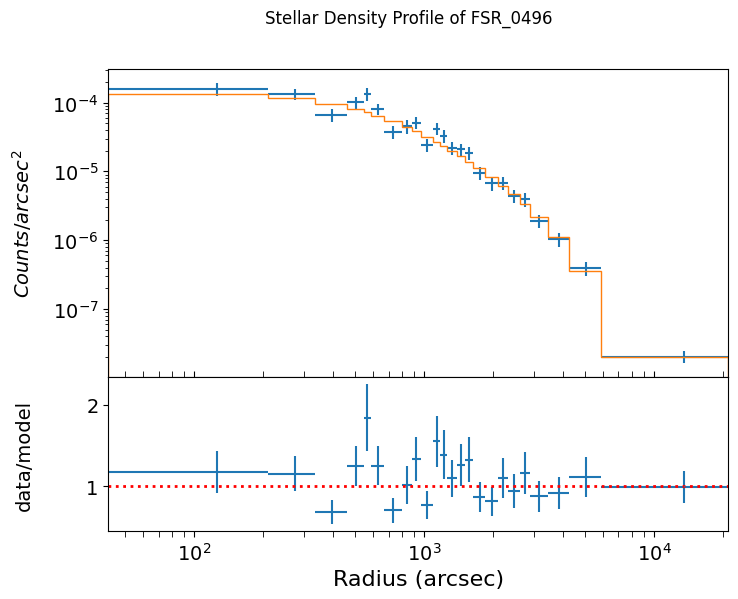

Minimum Chi-squared = 29.3824 for 20 d.o.f.
The goodness of fit is:  0.0805
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 48
    # data points      = 24
    # variables        = 4
    chi-square         = 29.3824316
    reduced chi-square = 1.46912158
    Akaike info crit   = 12.8562344
    Bayesian info crit = 17.5684498
[[Variables]]
    rho_0:  1.6701e-04 +/- 2.3395e-05 (14.01%) (init = 0.003)
    r_c:    618.166197 +/- 76.2815372 (12.34%) (init = 200)
    r_t:    7960.86068 +/- 887.398919 (11.15%) (init = 2000)
    c:      1.8059e-08 +/- 5.3431e-09 (29.59%) (init = 1e-06)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho_0, r_c) = -0.8280
    C(r_c, r_t)   = -0.6198
    C(r_t, c)     = -0.4253
    C(r_c, c)     = +0.2292
    C(rho_0, r_t) = +0.2012


In [160]:
result = fit_model(0)
report_fit(result)

<h4>Comments on Fit</h4>
The fit seems good but I would be happier with a slightly larger p-value for the goodness of fit. There seems to be some strong correlations between the parameters, especially between rho_0 and r_c. 

<h4>Obtaining confidence intervals</h4>

Results of MLE fitting
----------------------
Working on parameter r_c


C:\Users\shash\AppData\Local\Temp\ipykernel_27528\2198440143.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_data_selected['rad_dist'] = 3600*np.sqrt((star_data_selected['RAdeg'] - mean_RA)**2 + (star_data_selected['DEdeg'] - mean_DE)**2)


MLE r_c: 618.165 with errors: [-61.049  67.781]
Working on parameter r_t
MLE r_t: 7960.872 with errors: [-683.319  835.681]


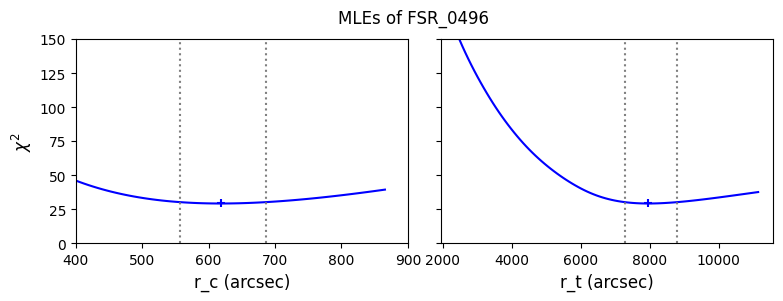

In [161]:
one_sigma_int(result, 0)

<h4>Comments on Intervals</h4>
The interval for $r_c$ looks extremely flat; this is important to us because we ideally want them to look parabolic so that we can use the second derivatives of L($\theta$) to estimate errors.

<h2>Cluster NGC 2671</h2>

C:\Users\shash\AppData\Local\Temp\ipykernel_27528\2198440143.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_data_selected['rad_dist'] = 3600*np.sqrt((star_data_selected['RAdeg'] - mean_RA)**2 + (star_data_selected['DEdeg'] - mean_DE)**2)


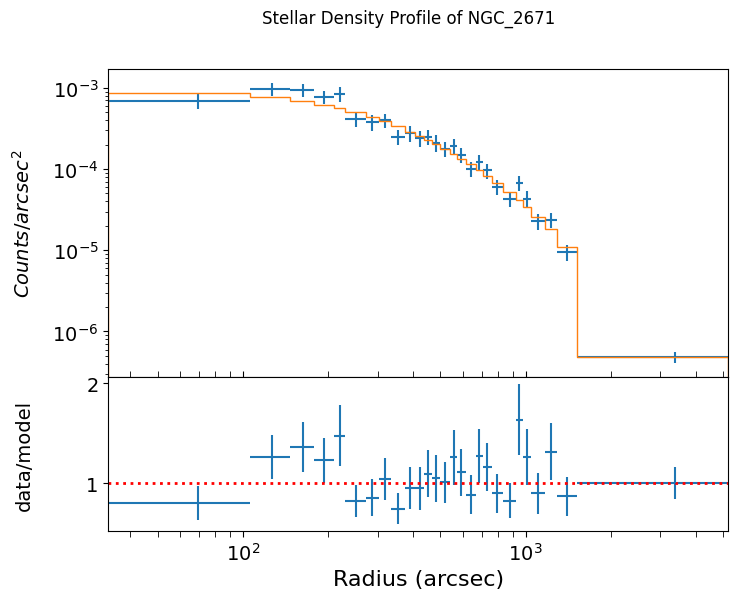

Minimum Chi-squared = 23.4656 for 23 d.o.f.
The goodness of fit is:  0.4339
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 27
    # variables        = 4
    chi-square         = 23.4656370
    reduced chi-square = 1.02024509
    Akaike info crit   = 4.21190621
    Bayesian info crit = 9.39525367
[[Variables]]
    rho_0:  0.00118467 +/- 1.0924e-04 (9.22%) (init = 0.003)
    r_c:    298.535916 +/- 33.0951740 (11.09%) (init = 200)
    r_t:    2624.75495 +/- 345.310305 (13.16%) (init = 2000)
    c:      1.9670e-07 +/- 1.6708e-07 (84.94%) (init = 1e-06)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_t, c)     = -0.8680
    C(r_c, r_t)   = -0.7463
    C(rho_0, r_c) = -0.6032
    C(r_c, c)     = +0.5750


In [162]:
result = fit_model(1)
report_fit(result)

<h4>Comments on Fit</h4>
The fit looks good and the g.o.f (0.4334) is reasonable.
Again, there are some strong correlations between the parameters.

<h4>Obtaining Confidence Intervals</h4>

C:\Users\shash\AppData\Local\Temp\ipykernel_27528\2198440143.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_data_selected['rad_dist'] = 3600*np.sqrt((star_data_selected['RAdeg'] - mean_RA)**2 + (star_data_selected['DEdeg'] - mean_DE)**2)


Results of MLE fitting
----------------------
Working on parameter r_c
MLE r_c: 298.536 with errors: [-31.255  36.04 ]
Working on parameter r_t
MLE r_t: 2624.751 with errors: [-293.445  411.903]


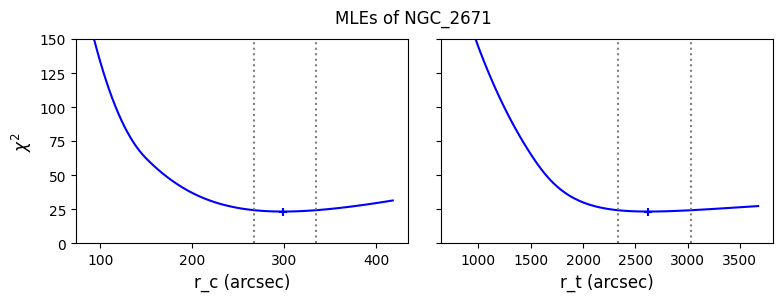

In [163]:
one_sigma_int(result, 1)

<h2>Cluster NGC 7086</h2>

C:\Users\shash\AppData\Local\Temp\ipykernel_27528\2198440143.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_data_selected['rad_dist'] = 3600*np.sqrt((star_data_selected['RAdeg'] - mean_RA)**2 + (star_data_selected['DEdeg'] - mean_DE)**2)


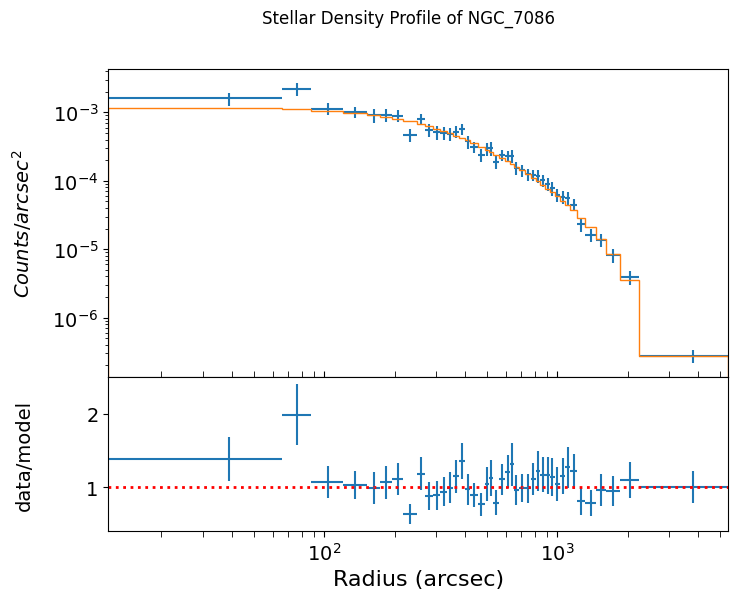

Minimum Chi-squared = 33.2415 for 38 d.o.f.
The goodness of fit is:  0.689
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 42
    # variables        = 4
    chi-square         = 33.2415215
    reduced chi-square = 0.87477688
    Akaike info crit   = -1.82253474
    Bayesian info crit = 5.12814373
[[Variables]]
    rho_0:  0.00149346 +/- 1.0405e-04 (6.97%) (init = 0.003)
    r_c:    324.820726 +/- 23.2404629 (7.15%) (init = 200)
    r_t:    2929.99645 +/- 166.908791 (5.70%) (init = 2000)
    c:      2.1235e-07 +/- 6.7639e-08 (31.85%) (init = 1e-06)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho_0, r_c) = -0.7551
    C(r_c, r_t)   = -0.6574
    C(r_t, c)     = -0.5515
    C(r_c, c)     = +0.3130
    C(rho_0, r_t) = +0.1354


In [164]:
result = fit_model(2)
report_fit(result)

<h4>Comments on Fit</h4>
The fit looks good here as well.

<h4>Obtaining Confidence Intervals</h4>

Results of MLE fitting
----------------------
Working on parameter r_c


C:\Users\shash\AppData\Local\Temp\ipykernel_27528\2198440143.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_data_selected['rad_dist'] = 3600*np.sqrt((star_data_selected['RAdeg'] - mean_RA)**2 + (star_data_selected['DEdeg'] - mean_DE)**2)


MLE r_c: 324.824 with errors: [-26.068  28.4  ]
Working on parameter r_t
MLE r_t: 2929.982 with errors: [-173.063  201.88 ]


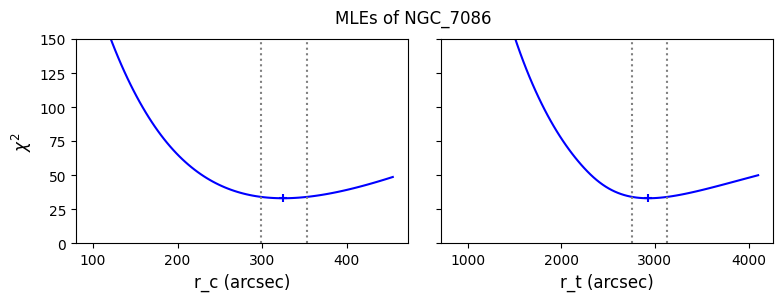

In [165]:
one_sigma_int(result, 2)

<h4>Comments on Intervals</h4>
Again, we see very asymmetric distributions for the MLEs.

<h3>General Comments on Task 2</h3>
There is a noticable difference in the errors quoted by the minimization method 'Minimizer' and the erorrs obtained by using the grid-search based code. The 'Minimizer' method quotes a symmetric error by assuming that the MLE is normally distributed around its mean (note that this is not the same as assuming the data is normally distributed within the bin). The grid search method, on the other hand, quotes a more unsymmetric errors. This makes sense if we look at the $\chi^2$ distribution for the MLEs and notice that they are not symmetric functions (for all three clusters). We can notice that the lower values of both $r_c$ and $r_t$ have a much steeper gradient compared to higher values (wrt to the mean). From this, we can infer that higher values for these parameters are more likely to be correct compared to lower values. <br>
The MLEs themselves seem to match between the two methods of calculating them. This makes sense as the peak itself isnt affected by the shape around it.<br>
We also notice that the parameters involved (especialyl $\rho$ and $r_c$) seem to have strong correlations. We cannot make conclusive predictions of whether these are true correlations as we dont know whether the assumptions made for these tests (that is, i.i.d.) is valid with the analysis we have carried out.

<h3>Assumptions Made in Task 2</h3>
For the first part of the task, we used a weighted least squares method to obtain the best fit parameters for each cluster. While doing this, we assumed that the data within each bin is normally distributed about its mean (the bin centre). We make this assumption since we are using $\chi^2$ statistics. This is a fair assumption to make since we ensured to re-bin the data such that each bin had a minimum of 20 counts (or stars) in it. When this condition is satisfied, the poisson distribution within the bin becomes close enough to a normal distribution for us to assume that it is normal. <br>

The lmfit Minimizer, while calculating errors, assumes that the MLEs are normally distributed around their peak. This, as we see when do the calculations using the parameter grids, is incorrect. This leads to the errors quoted by the lmfit method being less consistent with the grid search.

<h1>Task 3</h1>
<h2>General Overview of this task</h2>
Since this task is quite repetitive (in the sense we are doing the same analysis around 20 times), I will explain the general principle here. The goal is to identify whether any of the parameter in our clusters are dependant on the Gmag value of stars or the absolute proper motion of stars. In order to do this, we split the data into percentiles (based on Gmag first then proper motion). After this, we want to fit both datasets separately. We start of by fitting them with the assumption that the parameters are the same for both the datasets (this forms our null hypothesis). Then we allow one parameter to be 'free' and perform the fit again: that is, we ask the question 'what happens to the fit if, for example, $\rho_0$ is different for the two datasets but the rest of the parameters are the same. Of course, we need to know whether any improvement to the fit we get is statistically significant and in order to figure this out, we use Wilks' theorem and compare the $\Delta \chi^2$ for the two fits.

We then repeat the process again by freeing up another parameter and comparing it with the previous fit we obtained (this is to ensure that any improvement is only due to the parameter we are changing) and then repeat it for the data that is split based on pm and then do the entire thing for each of our 3 clusters.

<h2>Analysis</h2>We need to first split the sample based on 'percentiles'

In [167]:
# Add absolute proper motion
stars['abs_pm'] = np.sqrt(stars['pmRA']**2 + stars['pmDE']**2)
cluster_name = cluster_names[0]
cluster_data = calc_rad_dist(cluster_name, stars)
cluster_data.columns

C:\Users\shash\AppData\Local\Temp\ipykernel_27528\3173041971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stars['abs_pm'] = np.sqrt(stars['pmRA']**2 + stars['pmDE']**2)
C:\Users\shash\AppData\Local\Temp\ipykernel_27528\2198440143.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_data_selected['rad_dist'] = 3600*np.sqrt((star_data_selected['RAdeg'] - mean_RA)**2 + (star_data_selected['DEdeg'] - mean_DE)**2)


Index(['Name', 'ID', 'GaiaDR3', 'inrt', 'Prob', 'RAdeg', 'e_RAdeg', 'DEdeg',
       'e_DEdeg', 'GLON', 'GLAT', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Plx',
       'e_Plx', 'pscol', 'e_pscol', 'PlxpmRACor', 'PlxpmDECor', 'pmRApmDECor',
       'PlxpscolCor', 'pmRApscolCor', 'pmDEpscolCor', 'Solved', 'ELAT',
       'nueff', 'RUWE', 'FidelityV1', 'FG', 'e_FG', 'FBP', 'e_FBP', 'FRP',
       'e_FRP', 'Gmag', 'BPmag', 'RPmag', 'BP-RP', 'BP-G', 'G-RP', 'RV',
       'e_RV', 'n_RV', 'o_RV', 'o_RVd', 'GRVSmag', 'e_GRVSmag', 'o_GRVSmag',
       'Vbroad', 'e_Vbroad', 'o_Vbroad', 'VarFlag', 'NSS', 'RVS', 'abs_pm',
       'rad_dist'],
      dtype='object')

In [168]:
def split_data(df, param, low_int_pval = 0.49, high_int_pval = 0.51):
    """
    Splits a dataframe into different percentile ranges of the specified parameter.
    Returns two dataframes containing the lower section and higher section respectively.
    """
    # We first need to construct a pdf from the data
    pdf, edges = np.histogram(df[param], bins=20, density=True)
    centers = (edges[1:] + edges[:-1]) / 2

    # Convert pdf into a cdf
    cdf = spint.cumulative_trapezoid(pdf,centers, initial=0)

    # Convert cdf into a ppf 
    ppf = spinterp.interp1d(cdf, centers)
    
    # Identify parameter values that correspond to above p values
    interval = ppf([low_int_pval, high_int_pval])

    # Select percentiles based on p vals
    df_low = df[df[param] < interval[0]]
    df_high = df[df[param] > interval[1]]
     
    return df_low, df_high

In [169]:
def plot_split_data(data_low, data_high, param_split=None):
    """
    Calculates the model-fit parameters for two given sets of data. 
    Data needs to be for a single cluster and split based on a single parameter.
    """
    density_list = []
    r_edges_list = []
    err_counts_list = []
    # bin_widths_list = []
    for i, df in enumerate([data_low, data_high]):
        density, r_edges, err_counts, bin_widths = stellar_density(df)
        density_list.append(density)
        r_edges_list.append(r_edges)
        err_counts_list.append(err_counts)
        # bin_widths_list.append(bin_widths)
        r_centres = (r_edges[1:] + r_edges[:-1]) / 2
        if i == 0:
            plt_label = 'Lower Percentile'
        else:
            plt_label = 'Higher Percentile'
        plt.errorbar(r_centres, density, xerr=bin_widths/2., yerr=err_counts, fmt='.', label=plt_label)

    if param_split != None:
        plt.title(f'Stellar density profile for data split based on {param_split}')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.xlabel(f'Radius ($arcsec$)')
    plt.ylabel(f'Stellar Density ($counts/arcsec^2$)')

    return r_edges_list, density_list, err_counts_list

We need to now re-define our functions to work with multiple datasets. We can take these functions from the online material as well.

In [170]:
def model_bin_mult(xbins, model, i_data, params):
    '''
    General function for integrating the input model over bins defined by contiguous (no gaps) 
    bin edges, xbins.
       Inputs:
           xbins - x bin edges.
           model, params - the model name and associated Parameters object.
       Outputs:
           ymod - calculated counts-density model values for y-axis.
    '''
    i = 0
    ymod = np.zeros(len(xbins)-1)
    
    for i, xval in enumerate(xbins[:-1]):
        # We need to integrate over the area of each bin rather than the radius
        ymod[i], ymoderr = spint.quad(lambda x: 2 * np.pi * x * model(x, i_data, params),xbins[i],xbins[i+1]) 
        ymod[i] = ymod[i]/(np.pi * (xbins[i+1]**2-xbins[i]**2))  # we now divide by the bin area to match the counts density
        # units of our data
    return ymod

def lmf_lsq_binresid_mult(params,xdata,ydata,yerrs,model,output_resid=True):
    '''
    lmfit objective function to calculate and return residual array or model y-values for
        binned data where the xdata are the input bin edges and ydata are the densities (integral over bin
        divided by bin width).
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata, yerrs - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y-value array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (residuals) is
                        required output, otherwise a list of model y-value arrays (corresponding to the 
                        input x-data list) is returned.
        Output: if output_resid==True, returns a residual array of (y_i-y_model(x_i))/yerr_i which is
            concatenated into a single array for all input data errors (i.e. length is n1+n2 in 
            the example above). If output_resid==False, returns a list of y-model arrays (one per input x-array)
    '''
    if output_resid == True:
        for i, xvals in enumerate(xdata):  # loop through each input dataset and record residual array
                     # Note that we identify the dataset by counting from 1 not 0, this is just the 
                    # standard we will use for naming the parameters.
            if i == 0:
                resid = (ydata[i]-model_bin_mult(xdata[i],model,i+1,params))/yerrs[i]
            else:
                resid = np.append(resid,(ydata[i]-model_bin_mult(xdata[i],model,i+1,params))/yerrs[i])
        return resid
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin_mult(xdata[i],model,i+1,params))
        return ymodel

<h2>Cluster FSR 0496</h2>
We will perform our analysis one cluster at a time. <br>
<i>*Unfortunately, this does make the code quite a bit more lengthy*</i>

<h3>Splitting Based on Gmag</h3>

In [219]:
# Split data acc to Gmag and then plot
df_low, df_high = split_data(cluster_data, 'Gmag')

Let us test whether our splitting algorithm actually worked

Text(0.5, 1.0, 'Gmag distribution in cluster FSR 0496')

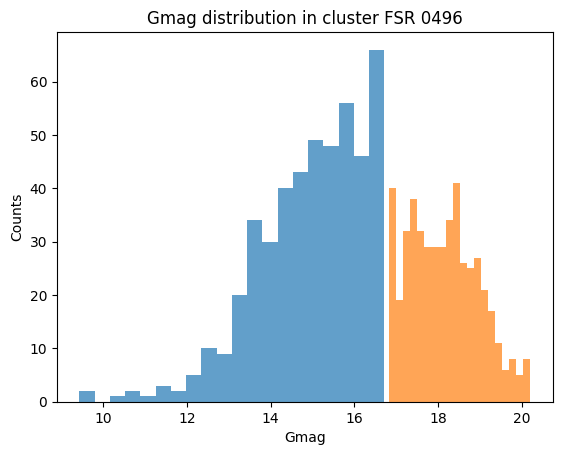

In [224]:
plt.hist(df_low['Gmag'], bins=20, label='Lower Percentile', alpha=0.7)
plt.hist(df_high['Gmag'], bins=20, label='Higher Percentile', alpha=0.7)
plt.xlabel('Gmag')
plt.ylabel('Counts')
plt.title('Gmag distribution in cluster FSR 0496')

That looks good, lets move on to our analysis. We first plot our split data

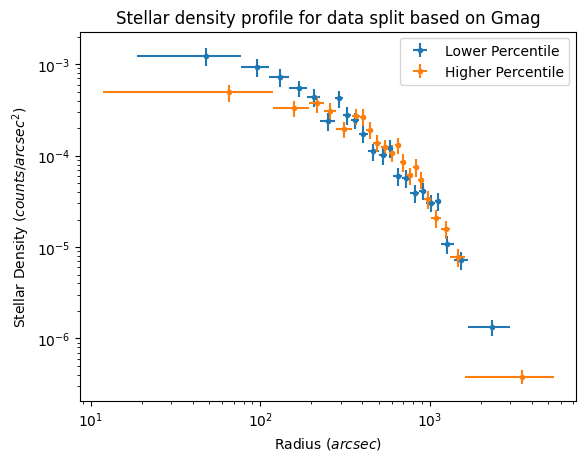

In [226]:
xdata, ydata, yerrs = plot_split_data(df_low, df_high, 'Gmag')

If the two subsamples we created are drawn from the same population, then they can be modelled using the same set of parameters. To test this, we create a separate set of parameters for each of the subsamples but set the constraint, using lmfit's properties, that the parameter values must be the same. <br>
For this test case, the null hypothesis is that the two subsamples have a single value for each of the parameters ($\rho_0, r_c, r_t, c$).

To implement this, we first define a model that can fit multiple data sets

In [172]:
def king_model_multi(r, i_data, params):
    """
    King model defined for radius values r (x) and a data index i. Calculates the predicted stellar density at given value(s) of radii
    Params needed: rho_0, r_c, r_t, c
    """
    param_vals = params.valuesdict()

    if r <= param_vals['r_t_'+str(i_data)]:
        return param_vals['rho_0_'+str(i_data)] * ((1 / np.sqrt(1 + (r/param_vals['r_c_'+str(i_data)])**2)) - (1 / np.sqrt(1 + (param_vals['r_t_'+str(i_data)]/param_vals['r_c_'+str(i_data)])**2)))**2 + param_vals['c_'+str(i_data)]
    else: 
        return param_vals['c_'+str(i_data)]

Now we set up the parameters such that the model sets all parameters for both subsamples to be equal

In [173]:
params_null = Parameters()
params_null.add_many(('rho_0_1',0.003, True, 0),('r_c_1',200, True, 0), ('r_t_1',2000, True, 0), ('c_1',1e-6, True, 0),
                ('rho_0_2',0.003,True,None,None,'rho_0_1'),('r_c_2',200,True,None,None,'r_c_1'), 
                ('r_t_2',2000,True,None,None,'r_t_1'),('c_2',1e-6, True, None, None, 'c_1'))

And then perform the fit for our null hypothesis

In [174]:
model = king_model_multi
output_resid = True
set_function = Minimizer(lmf_lsq_binresid_mult, params_null, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result_null = set_function.minimize(method = 'leastsq')
report_fit(result_null)
print("Minimum Chi-squared = "+str(result_null.chisqr.round(4))+" for "+str(result_null.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result_null.chisqr,df=result_null.nfree).round(4))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 23
    # variables        = 4
    chi-square         = 24.3763555
    reduced chi-square = 1.28296608
    Akaike info crit   = 9.33674646
    Bayesian info crit = 13.8787233
##  Warning: uncertainties could not be estimated:
    c_1:      at boundary
[[Variables]]
    rho_0_1:  9.3679e-05 (init = 0.003)
    r_c_1:    527.055791 (init = 200)
    r_t_1:    10068.7822 (init = 2000)
    c_1:      3.6837e-13 (init = 1e-06)
    rho_0_2:  9.3679e-05 == 'rho_0_1'
    r_c_2:    527.055791 == 'r_c_1'
    r_t_2:    10068.7822 == 'r_t_1'
    c_2:      3.6837e-13 == 'c_1'
Minimum Chi-squared = 24.3764 for 19 d.o.f.
The goodness of fit is:  0.1821


This seems like a good fit

We can now define a function to plot our results

In [175]:
def plot_spec_model_mult(ebins_list,cdens_list,cdens_err_list,cdens_model_list,emin,emax,resid_type,
                         legend_labels):
    '''Plot the binned (GeV) spectrum with the model as a histogram, and 
       data/model residuals.
       Inputs:
           ebins_list - energy bin edges.
           cdens_list, cdens_err_list - counts density and its error.
           cdens_model_list - model counts density.
           emin, emax - minimum and maximum energy to be plotted
           resid_type - string, type of data vs model residuals, these can be: 
               ratio: data/model, resid: data-model, weighted resid: data-model/error
           legend_labels - list of labels for each dataset to use in legend, 
                   use None if no legend required'''
    
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.subplots_adjust(hspace=0)
    for i,ebins in enumerate(ebins_list):
        energies = (ebins[1:]+ebins[:-1])/2
        bwidths = np.diff(ebins)
        if legend_labels != None:
            label_txt = legend_labels[i]
        # Note that colours in the default Matplotlib colour cycle can be specified using strings 
        # 'C0'..'C9', which is useful for plotting the same colours for model and data.
        ax1.errorbar(energies, cdens_list[i], xerr=bwidths/2., yerr=cdens_err_list[i], 
                     color='C'+str(i), markersize=4, fmt='o', label=label_txt)
        model_hist, edges, patches = ax1.hist(energies, bins=ebins, weights=cdens_model_list[i], 
                    density=False, histtype='step', color='C'+str(i), alpha=0.5, 
                                              linestyle='dotted', linewidth=2)
        if resid_type == 'ratio':
            ax2.errorbar(energies, cdens_list[i]/cdens_model_list[i], xerr=bwidths/2., 
                    yerr=cdens_err_list[i]/cdens_model_list[i], color='C'+str(i), markersize=4, fmt='o')
        elif resid_type == 'resid':
            ax2.errorbar(energies, (cdens_list[i]-cdens_model_list[i]), xerr=bwidths/2., 
                    yerr=cdens_err_list[i], color='C'+str(i), markersize=4, fmt='o')
        elif resid_type == 'weighted resid':
            ax2.errorbar(energies, (cdens_list[i]-cdens_model_list[i])/cdens_err_list[i], xerr=bwidths/2., 
                    yerr=1.0, color='C'+str(i), markersize=4, fmt='o')
    ax2.set_xlabel("Radius (arcsec)", fontsize=14)
    ax1.set_ylabel("Counts/arcsec^2", fontsize=14)
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
    if resid_type == 'ratio':
        ax2.set_ylabel("data/model", fontsize=14)
        ax2.axhline(1., color='gray', linestyle='dotted', lw=2)
    elif resid_type == 'resid':
        ax2.set_ylabel("data-model", fontsize=14)
        ax2.axhline(0., color='gray', linestyle='dotted', lw=2)
    elif resid_type == 'weighted resid':
        ax2.get_yaxis().set_label_coords(-0.09,0.5)
        ax2.set_ylabel(r"$\frac{data-model}{error}$", fontsize=16)
        ax2.axhline(0., color='gray', linestyle='dotted', lw=2)
    ax1.tick_params(labelsize=14)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax2.tick_params(labelsize=14)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    # ax2.set_xlim(emin,emax) # Strictly speaking we should only show the energy range 
    # where data is sampled, to avoid impression from model that the flux suddenly drops 
    # at the boundaries.
    ax1.legend(fontsize=14)
    plt.show()

And plot the models for our subsamples

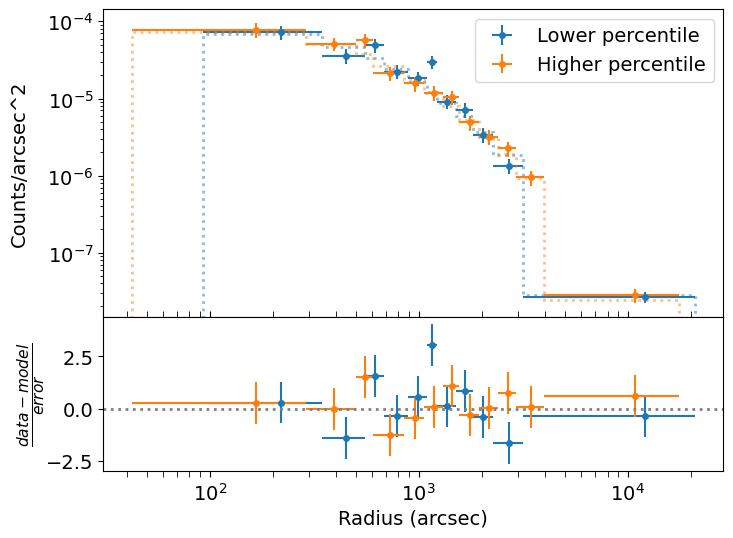

In [176]:
# To calculate the best-fitting model values, use the parameters of the best fit output
# from the fit, result.params and set output_resid=false to output a list of model y-values:
model_vals = lmf_lsq_binresid_mult(result_null.params,xdata,ydata,yerrs,model,output_resid=False)
# Now plot the data and model and residuals
legend_labels = ['Lower percentile', 'Higher percentile']
plot_spec_model_mult(xdata,ydata,yerrs,model_vals,10,200,'weighted resid',legend_labels)

There is nothing that stands out about the fit in the plot here.

Let us now define a function that allows us to compare and check whether there are improvements in a fit for different sets of parameters

In [177]:
def compare_fits(params_to_compare, results_null):
    """
    Computes fit for params given and compares with given results.
    """
    model = king_model_multi
    output_resid = True
    set_function = Minimizer(lmf_lsq_binresid_mult, params_to_compare, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
    result_altern = set_function.minimize(method = 'leastsq')

    report_fit(result_altern)

    print("Minimum Chi-squared for the new set of params is "+str(result_altern.chisqr.round(4))+" for "+str(result_altern.nfree)+" d.o.f.")
    print("The goodness of fit is: ",sps.chi2.sf(result_altern.chisqr,df=result_altern.nfree))

    m = results_null.nfree-result_altern.nfree
    deltachisq = results_null.chisqr-result_altern.chisqr
    print("p-value for our delta-chi-squared: ",sps.chi2.sf(deltachisq,df=m),"for",m,"fewer constraints.")

    return result_altern

Let us define parameters that will allow us to check if freeing any of them up improves the fit.

In [178]:
params_rho_free = Parameters()
params_rho_free.add_many(('rho_0_1',0.003, True, 0),('r_c_1',200, True, 0), ('r_t_1',2000, True, 0), ('c_1',1e-6, True, 0),
                ('rho_0_2',0.003, True, 0),('r_c_2',200,True,None,None,'r_c_1'), 
                ('r_t_2',2000, True, None, None, 'r_t_1'), ('c_2',1e-6, True, None, None, 'c_1'))
params_r_c_free = Parameters()
params_r_c_free.add_many(('rho_0_1',0.003, True, 0),('r_c_1',200, True, 0), ('r_t_1',2000, True, 0), ('c_1',1e-6, True, 0),
                ('rho_0_2',0.003, True, 0),('r_c_2',200, True, 0), 
                ('r_t_2',2000, True, None, None, 'r_t_1'), ('c_2',1e-6, True, None, None, 'c_1'))

params_r_t_free = Parameters()
params_r_t_free.add_many(('rho_0_1',0.003, True, 0),('r_c_1',200, True, 0), ('r_t_1',2000, True, 0), ('c_1',1e-6, True, 0),
                ('rho_0_2',0.003, True, 0),('r_c_2',200, True, 0), 
                ('r_t_2',2000, True, 0), ('c_2',1e-6, True, None, None, 'c_1'))

Let us now free up the parameter '$\rho_0$' and check if that improves the fit.

In [179]:
result_rho_free = compare_fits(params_rho_free, result_null)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 99
    # data points      = 23
    # variables        = 5
    chi-square         = 23.9724086
    reduced chi-square = 1.33180048
    Akaike info crit   = 10.9524142
    Bayesian info crit = 16.6298853
[[Variables]]
    rho_0_1:  9.0728e-05 +/- 1.4281e-05 (15.74%) (init = 0.003)
    r_c_1:    551.740156 +/- 82.7517058 (15.00%) (init = 200)
    r_t_1:    8790.15285 +/- 2533.90388 (28.83%) (init = 2000)
    c_1:      6.3700e-09 +/- 1.2572e-08 (197.37%) (init = 1e-06)
    rho_0_2:  9.4415e-05 +/- 1.4569e-05 (15.43%) (init = 0.003)
    r_c_2:    551.740156 +/- 82.7517055 (15.00%) == 'r_c_1'
    r_t_2:    8790.15285 +/- 2533.90388 (28.83%) == 'r_t_1'
    c_2:      6.3700e-09 +/- 1.2572e-08 (197.37%) == 'c_1'
[[Correlations]] (unreported correlations are < 0.100)
    C(r_t_1, c_1)       = -0.9375
    C(rho_0_1, rho_0_2) = +0.7661
    C(r_c_1, r_t_1)     = -0.7396
    C(rho_0_1, r_c_1)   = -0.7260
    C(r_c_1, rho_0_

We can use Wilk's theorem to do check whether the change in $\chi^2$ is significant - which is what we are doing. This states that, if our null hypothesis is correct and the improvement of our fit is due to random chance, the difference in $\chi^2$ ($\Delta \chi^2$)will follow a $\chi^2$ distribution. 

The p-value of 0.5251 above suggests that the result is just due to random chance and hence rho_0 is not different for the two subsamples

Let us now free up $r_c$ as well and see if that makes a difference.

In [180]:
result_r_c_free = compare_fits(params_r_c_free, result_rho_free)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 151
    # data points      = 23
    # variables        = 6
    chi-square         = 23.8703530
    reduced chi-square = 1.40413841
    Akaike info crit   = 12.8542893
    Bayesian info crit = 19.6672546
[[Variables]]
    rho_0_1:  9.3781e-05 +/- 1.9744e-05 (21.05%) (init = 0.003)
    r_c_1:    540.073005 +/- 95.1519693 (17.62%) (init = 200)
    r_t_1:    8712.39231 +/- 2556.82653 (29.35%) (init = 2000)
    c_1:      6.7871e-09 +/- 1.2802e-08 (188.63%) (init = 1e-06)
    rho_0_2:  9.0584e-05 +/- 1.8818e-05 (20.77%) (init = 0.003)
    r_c_2:    570.437713 +/- 109.474263 (19.19%) (init = 200)
    r_t_2:    8712.39231 +/- 2556.82654 (29.35%) == 'r_t_1'
    c_2:      6.7871e-09 +/- 1.2802e-08 (188.63%) == 'c_1'
[[Correlations]] (unreported correlations are < 0.100)
    C(r_t_1, c_1)     = -0.9363
    C(rho_0_1, r_c_1) = -0.8069
    C(rho_0_2, r_c_2) = -0.8013
    C(r_t_1, r_c_2)   = -0.6766
    C(c_1, r_c_2)     = 

The p-value of 0.7497 does not suggest that the fits are different here either.<br>
Let us now try freeing up $r_t$ as well

In [181]:
result_r_t_free = compare_fits(params_r_t_free, result_r_c_free)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 121
    # data points      = 23
    # variables        = 7
    chi-square         = 21.2104931
    reduced chi-square = 1.32565582
    Akaike info crit   = 12.1370414
    Bayesian info crit = 20.0855009
[[Variables]]
    rho_0_1:  8.9263e-05 +/- 1.4879e-05 (16.67%) (init = 0.003)
    r_c_1:    694.402249 +/- 152.439175 (21.95%) (init = 200)
    r_t_1:    5696.00444 +/- 1450.79871 (25.47%) (init = 2000)
    c_1:      1.6157e-08 +/- 7.9602e-09 (49.27%) (init = 1e-06)
    rho_0_2:  9.2647e-05 +/- 1.8625e-05 (20.10%) (init = 0.003)
    r_c_2:    566.733784 +/- 100.057834 (17.66%) (init = 200)
    r_t_2:    8145.99353 +/- 1725.17084 (21.18%) (init = 2000)
    c_2:      1.6157e-08 +/- 7.9602e-09 (49.27%) == 'c_1'
[[Correlations]] (unreported correlations are < 0.100)
    C(rho_0_2, r_c_2) = -0.8294
    C(r_t_1, c_1)     = -0.7839
    C(r_c_1, r_t_1)   = -0.7813
    C(c_1, r_t_2)     = -0.7373
    C(r_c_2, r_t_2)   =

This is not a good enough p-value either: it seems like the stellar density parameters ($\rho_0, r_t, r_c$) are not dependant on Gmag for this cluster

<h3>Splitting Based on absolute proper motion</h3>

Let us now repeat the same process but by splitting the data based on absolut proper motion

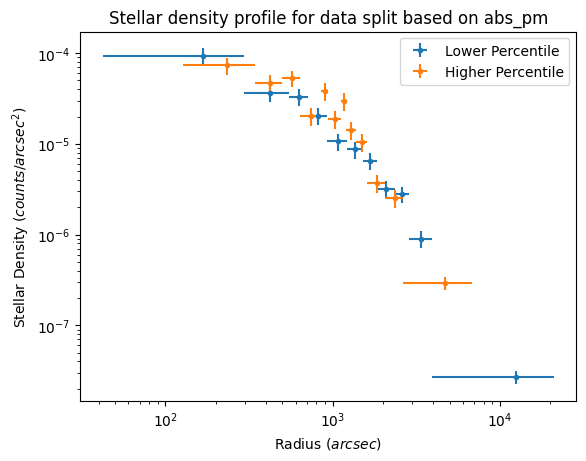

In [182]:
# Split data acc to Gmag and then plot
df_low, df_high = split_data(cluster_data, 'abs_pm')
xdata, ydata, yerrs = plot_split_data(df_low, df_high, 'abs_pm')

Null Hypothesis:

In [183]:
params_null = Parameters()
params_null.add_many(('rho_0_1',0.003, True, 0),('r_c_1',200, True, 0), ('r_t_1',2000, True, 0), ('c_1',1e-6, True, 0),
                ('rho_0_2',0.003,True,None,None,'rho_0_1'),('r_c_2',200,True,None,None,'r_c_1'), 
                ('r_t_2',2000,True,None,None,'r_t_1'),('c_2',1e-6, True, None, None, 'c_1'))

model = king_model_multi
output_resid = True
set_function = Minimizer(lmf_lsq_binresid_mult, params_null, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result_null = set_function.minimize(method = 'leastsq')
report_fit(result_null)
print("Minimum Chi-squared = "+str(result_null.chisqr)+" for "+str(result_null.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result_null.chisqr,df=result_null.nfree))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 23
    # variables        = 4
    chi-square         = 32.0665890
    reduced chi-square = 1.68771521
    Akaike info crit   = 15.6433699
    Bayesian info crit = 20.1853468
[[Variables]]
    rho_0_1:  8.9991e-05 +/- 1.4807e-05 (16.45%) (init = 0.003)
    r_c_1:    579.910886 +/- 87.6639449 (15.12%) (init = 200)
    r_t_1:    7734.96600 +/- 1204.13928 (15.57%) (init = 2000)
    c_1:      1.8046e-08 +/- 7.2936e-09 (40.42%) (init = 1e-06)
    rho_0_2:  8.9991e-05 +/- 1.4807e-05 (16.45%) == 'rho_0_1'
    r_c_2:    579.910886 +/- 87.6639447 (15.12%) == 'r_c_1'
    r_t_2:    7734.96600 +/- 1204.13928 (15.57%) == 'r_t_1'
    c_2:      1.8046e-08 +/- 7.2936e-09 (40.42%) == 'c_1'
[[Correlations]] (unreported correlations are < 0.100)
    C(rho_0_1, r_c_1) = -0.8323
    C(r_c_1, r_t_1)   = -0.6633
    C(r_t_1, c_1)     = -0.5871
    C(r_c_1, c_1)     = +0.3013
    C(rho_0_1, r_t_1) = +0.2452

Plot of the fit:

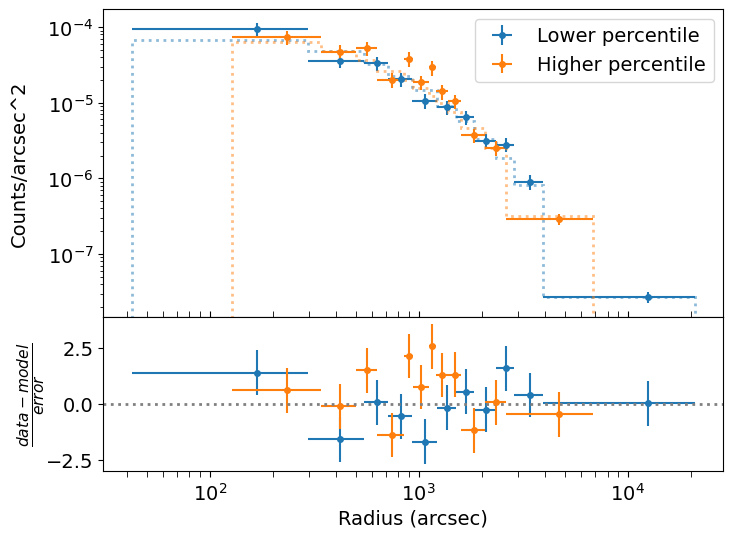

In [184]:
# To calculate the best-fitting model values, use the parameters of the best fit output
# from the fit, result.params and set output_resid=false to output a list of model y-values:
model_vals = lmf_lsq_binresid_mult(result_null.params,xdata,ydata,yerrs,model,output_resid=False)
# Now plot the data and model and residuals
legend_labels = ['Lower percentile', 'Higher percentile']
plot_spec_model_mult(xdata,ydata,yerrs,model_vals,10,200,'weighted resid',legend_labels)

Freeing up just $\rho_0$:

Let us now free up the parameter '$\rho_0$' and check if that improves the fit.

In [185]:
result_rho_free = compare_fits(params_rho_free, result_null)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 23
    # variables        = 5
    chi-square         = 30.8342148
    reduced chi-square = 1.71301193
    Akaike info crit   = 16.7420067
    Bayesian info crit = 22.4194778
[[Variables]]
    rho_0_1:  8.5524e-05 +/- 1.4986e-05 (17.52%) (init = 0.003)
    r_c_1:    587.882725 +/- 89.0182432 (15.14%) (init = 200)
    r_t_1:    7473.32778 +/- 1123.43683 (15.03%) (init = 2000)
    c_1:      1.9335e-08 +/- 7.1130e-09 (36.79%) (init = 1e-06)
    rho_0_2:  9.5313e-05 +/- 1.6619e-05 (17.44%) (init = 0.003)
    r_c_2:    587.882725 +/- 89.0182431 (15.14%) == 'r_c_1'
    r_t_2:    7473.32778 +/- 1123.43683 (15.03%) == 'r_t_1'
    c_2:      1.9335e-08 +/- 7.1130e-09 (36.79%) == 'c_1'
[[Correlations]] (unreported correlations are < 0.100)
    C(rho_0_1, r_c_1)   = -0.7966
    C(r_c_1, rho_0_2)   = -0.7471
    C(rho_0_1, rho_0_2) = +0.7414
    C(r_c_1, r_t_1)     = -0.6613
    C(r_t_1, c_1)    

The p-value of 0.2670 above suggests that the result is just due to random chance and hence rho_0 is not different for the two subsamples

Let us now free up $r_c$ as well and see if that makes a difference.

In [186]:
result_r_c_free = compare_fits(params_r_c_free, result_rho_free)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 94
    # data points      = 23
    # variables        = 6
    chi-square         = 30.3911673
    reduced chi-square = 1.78771572
    Akaike info crit   = 18.4091294
    Bayesian info crit = 25.2220947
[[Variables]]
    rho_0_1:  7.7774e-05 +/- 1.8123e-05 (23.30%) (init = 0.003)
    r_c_1:    632.117928 +/- 120.310477 (19.03%) (init = 200)
    r_t_1:    7555.58160 +/- 1205.97950 (15.96%) (init = 2000)
    c_1:      1.8653e-08 +/- 7.5782e-09 (40.63%) (init = 1e-06)
    rho_0_2:  1.0170e-04 +/- 2.3794e-05 (23.40%) (init = 0.003)
    r_c_2:    556.937671 +/- 111.487479 (20.02%) (init = 200)
    r_t_2:    7555.58160 +/- 1205.97950 (15.96%) == 'r_t_1'
    c_2:      1.8653e-08 +/- 7.5782e-09 (40.63%) == 'c_1'
[[Correlations]] (unreported correlations are < 0.100)
    C(rho_0_1, r_c_1) = -0.8602
    C(rho_0_2, r_c_2) = -0.8578
    C(r_t_1, r_c_2)   = -0.6240
    C(r_t_1, c_1)     = -0.5901
    C(r_c_1, r_t_1)   = -0.

The p-value of 0.5057 does not suggest that the fits are different here either.<br>
Let us now try freeing up $r_t$ as well

In [187]:
result_r_t_free = compare_fits(params_r_t_free, result_r_c_free)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 117
    # data points      = 23
    # variables        = 7
    chi-square         = 27.4731557
    reduced chi-square = 1.71707223
    Akaike info crit   = 18.0874486
    Bayesian info crit = 26.0359081
##  Warning: uncertainties could not be estimated:
    c_1:      at boundary
[[Variables]]
    rho_0_1:  8.8789e-05 (init = 0.003)
    r_c_1:    488.803380 (init = 200)
    r_t_1:    13574.6896 (init = 2000)
    c_1:      2.7724e-12 (init = 1e-06)
    rho_0_2:  9.8152e-05 (init = 0.003)
    r_c_2:    594.663985 (init = 200)
    r_t_2:    7150.16600 (init = 2000)
    c_2:      2.7724e-12 == 'c_1'
Minimum Chi-squared for the new set of params is 27.4732 for 16 d.o.f.
The goodness of fit is:  0.036514318523245035
p-value for our delta-chi-squared:  0.08759574478934301 for 1 fewer constraints.


This is not a good enough p-value either (0.0876): it seems like the stellar density parameters ($\rho_0, r_t, r_c$) are not dependant on the proper motion for this cluster

<h3>General Comments and Summary of Results for Cluster FSR 0496</h3>
We have found that the parameters for this cluster do not seem to be dependant on either the proper motion or the Gmag of stars in the cluster.

<h2>Cluster NGC 2671</h2>

In [188]:
# Add absolute proper motion
stars['abs_pm'] = np.sqrt(stars['pmRA']**2 + stars['pmDE']**2)
cluster_name = cluster_names[1]
cluster_data = calc_rad_dist(cluster_name, stars)

C:\Users\shash\AppData\Local\Temp\ipykernel_27528\1390056672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stars['abs_pm'] = np.sqrt(stars['pmRA']**2 + stars['pmDE']**2)
C:\Users\shash\AppData\Local\Temp\ipykernel_27528\2198440143.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_data_selected['rad_dist'] = 3600*np.sqrt((star_data_selected['RAdeg'] - mean_RA)**2 + (star_data_selected['DEdeg'] - mean_DE)**2)


<h3>Splitting Based on Gmag</h3>

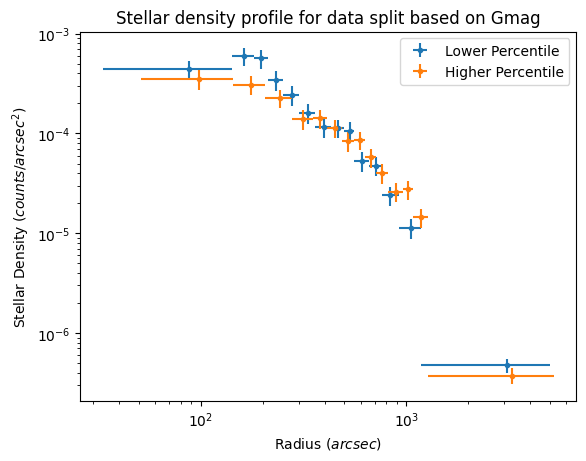

In [189]:
# Split data acc to Gmag and then plot
df_low, df_high = split_data(cluster_data, 'Gmag')
xdata, ydata, yerrs = plot_split_data(df_low, df_high, 'Gmag')

Now we set up the parameters such that the model sets all parameters for both subsamples to be equal

In [190]:
params_null = Parameters()
params_null.add_many(('rho_0_1',0.003, True, 0),('r_c_1',200, True, 0), ('r_t_1',2000, True, 0), ('c_1',1e-6, True, 0),
                ('rho_0_2',0.003,True,None,None,'rho_0_1'),('r_c_2',200,True,None,None,'r_c_1'), 
                ('r_t_2',2000,True,None,None,'r_t_1'),('c_2',1e-6, True, None, None, 'c_1'))

And then perform the fit for our null hypothesis

In [191]:
model = king_model_multi
output_resid = True
set_function = Minimizer(lmf_lsq_binresid_mult, params_null, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result_null = set_function.minimize(method = 'leastsq')
report_fit(result_null)
print("Minimum Chi-squared = "+str(result_null.chisqr.round(4))+" for "+str(result_null.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result_null.chisqr,df=result_null.nfree).round(4))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 54
    # data points      = 28
    # variables        = 4
    chi-square         = 26.4493967
    reduced chi-square = 1.10205819
    Akaike info crit   = 6.40480744
    Bayesian info crit = 11.7336255
##  Warning: uncertainties could not be estimated:
    c_1:      at boundary
[[Variables]]
    rho_0_1:  5.9426e-04 (init = 0.003)
    r_c_1:    274.871653 (init = 200)
    r_t_1:    2955.24987 (init = 2000)
    c_1:      2.7045e-13 (init = 1e-06)
    rho_0_2:  5.9426e-04 == 'rho_0_1'
    r_c_2:    274.871653 == 'r_c_1'
    r_t_2:    2955.24987 == 'r_t_1'
    c_2:      2.7045e-13 == 'c_1'
Minimum Chi-squared = 26.4494 for 24 d.o.f.
The goodness of fit is:  0.3308


This seems like a good fit

Let us plot the models for our subsamples

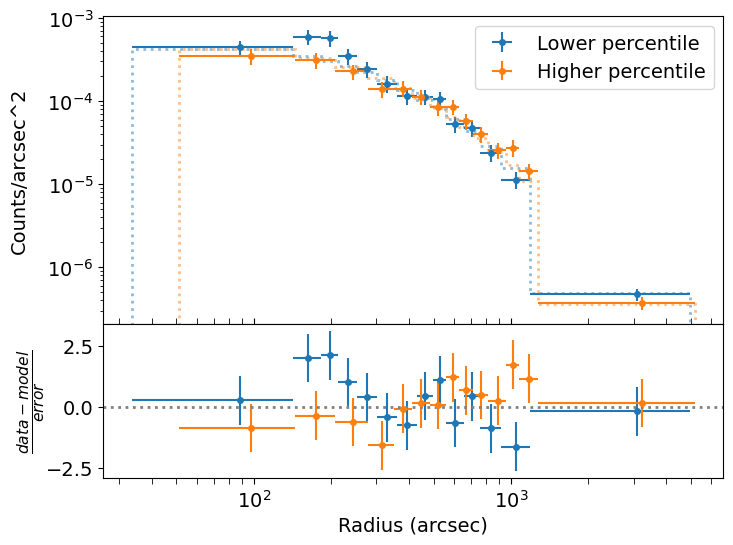

In [192]:
# To calculate the best-fitting model values, use the parameters of the best fit output
# from the fit, result.params and set output_resid=false to output a list of model y-values:
model_vals = lmf_lsq_binresid_mult(result_null.params,xdata,ydata,yerrs,model,output_resid=False)
# Now plot the data and model and residuals
legend_labels = ['Lower percentile', 'Higher percentile']
plot_spec_model_mult(xdata,ydata,yerrs,model_vals,10,200,'weighted resid',legend_labels)

There is nothing that stands out about the fit in the plot here.

Let us now free up the parameter '$\rho_0$' and check if that improves the fit.

In [193]:
result_rho_free = compare_fits(params_rho_free, result_null)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 28
    # variables        = 5
    chi-square         = 26.4477650
    reduced chi-square = 1.14990283
    Akaike info crit   = 8.40308006
    Bayesian info crit = 15.0641026
##  Warning: uncertainties could not be estimated:
    c_1:      at boundary
[[Variables]]
    rho_0_1:  5.9269e-04 (init = 0.003)
    r_c_1:    275.104132 (init = 200)
    r_t_1:    2954.82379 (init = 2000)
    c_1:      7.0917e-12 (init = 1e-06)
    rho_0_2:  5.9472e-04 (init = 0.003)
    r_c_2:    275.104132 == 'r_c_1'
    r_t_2:    2954.82379 == 'r_t_1'
    c_2:      7.0917e-12 == 'c_1'
Minimum Chi-squared for the new set of params is 26.4478 for 23 d.o.f.
The goodness of fit is:  0.28018698816445675
p-value for our delta-chi-squared:  0.9677790617131599 for 1 fewer constraints.


The p-value of 0.9678 above suggests that the result is just due to random chance and hence rho_0 is not different for the two subsamples

Let us now free up $r_c$ as well and see if that makes a difference.

In [194]:
result_r_c_free = compare_fits(params_r_c_free, result_rho_free)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 71
    # data points      = 28
    # variables        = 6
    chi-square         = 17.0504577
    reduced chi-square = 0.77502080
    Akaike info crit   = -1.88876893
    Bayesian info crit = 6.10445813
[[Variables]]
    rho_0_1:  7.8003e-04 +/- 9.6319e-05 (12.35%) (init = 0.003)
    r_c_1:    235.054913 +/- 29.5432699 (12.57%) (init = 200)
    r_t_1:    2654.56839 +/- 528.726905 (19.92%) (init = 2000)
    c_1:      6.7481e-08 +/- 1.7299e-07 (256.35%) (init = 1e-06)
    rho_0_2:  4.6113e-04 +/- 5.1804e-05 (11.23%) (init = 0.003)
    r_c_2:    372.113979 +/- 53.8246936 (14.46%) (init = 200)
    r_t_2:    2654.56839 +/- 528.726906 (19.92%) == 'r_t_1'
    c_2:      6.7481e-08 +/- 1.7299e-07 (256.35%) == 'c_1'
[[Correlations]] (unreported correlations are < 0.100)
    C(r_t_1, c_1)     = -0.9537
    C(r_t_1, r_c_2)   = -0.7504
    C(r_c_1, r_t_1)   = -0.6895
    C(rho_0_1, r_c_1) = -0.6590
    C(c_1, r_c_2)     = 

The p-value of 0.0021 suggests that the fits are different here to a 3-$\sigma$ confidence. Hence, it is likely that $r_c$ is dependent on the Gmag of the cluster<br>
Let us now try freeing up $r_t$ as well

In [195]:
result_r_t_free = compare_fits(params_r_t_free, result_r_c_free)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 89
    # data points      = 28
    # variables        = 7
    chi-square         = 16.7272259
    reduced chi-square = 0.79653457
    Akaike info crit   = -0.42467105
    Bayesian info crit = 8.90076052
[[Variables]]
    rho_0_1:  7.8493e-04 +/- 1.0205e-04 (13.00%) (init = 0.003)
    r_c_1:    226.034993 +/- 30.6307350 (13.55%) (init = 200)
    r_t_1:    2846.61618 +/- 638.904024 (22.44%) (init = 2000)
    c_1:      4.5369e-08 +/- 1.8880e-07 (416.14%) (init = 1e-06)
    rho_0_2:  4.5591e-04 +/- 5.2168e-05 (11.44%) (init = 0.003)
    r_c_2:    382.297577 +/- 61.9736929 (16.21%) (init = 200)
    r_t_2:    2627.79770 +/- 576.145260 (21.93%) (init = 2000)
    c_2:      4.5369e-08 +/- 1.8880e-07 (416.14%) == 'c_1'
[[Correlations]] (unreported correlations are < 0.100)
    C(c_1, r_t_2)     = -0.9310
    C(r_t_1, c_1)     = -0.9135
    C(r_t_1, r_t_2)   = +0.8505
    C(r_c_2, r_t_2)   = -0.7859
    C(r_c_1, r_t_1)  

The p val of 0.5697 is not good enough it seems like $r_t$ is not dependant on the Gmag of the cluster.

<h3>Splitting Based on absolute proper motion</h3>

Let us now repeat the same process but by splitting the data based on absolut proper motion

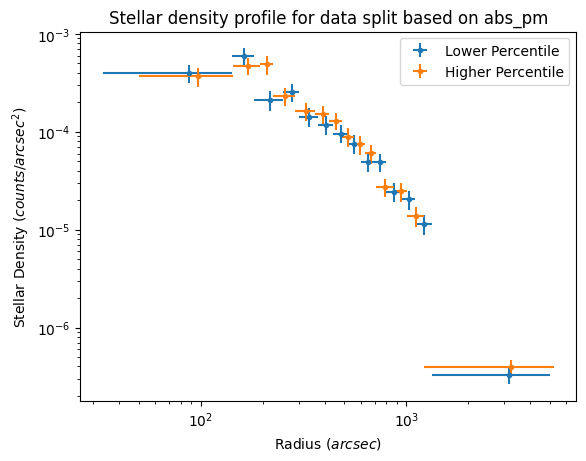

In [196]:
# Split data acc to Gmag and then plot
df_low, df_high = split_data(cluster_data, 'abs_pm')
xdata, ydata, yerrs = plot_split_data(df_low, df_high, 'abs_pm')

Null Hypothesis:

In [197]:
params_null = Parameters()
params_null.add_many(('rho_0_1',0.003, True, 0),('r_c_1',200, True, 0), ('r_t_1',2000, True, 0), ('c_1',1e-6, True, 0),
                ('rho_0_2',0.003,True,None,None,'rho_0_1'),('r_c_2',200,True,None,None,'r_c_1'), 
                ('r_t_2',2000,True,None,None,'r_t_1'),('c_2',1e-6, True, None, None, 'c_1'))

model = king_model_multi
output_resid = True
set_function = Minimizer(lmf_lsq_binresid_mult, params_null, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result_null = set_function.minimize(method = 'leastsq')
report_fit(result_null)
print("Minimum Chi-squared = "+str(result_null.chisqr)+" for "+str(result_null.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result_null.chisqr,df=result_null.nfree))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 28
    # variables        = 4
    chi-square         = 20.0179362
    reduced chi-square = 0.83408068
    Akaike info crit   = -1.39612316
    Bayesian info crit = 3.93269488
##  Warning: uncertainties could not be estimated:
    c_1:      at boundary
[[Variables]]
    rho_0_1:  5.8004e-04 (init = 0.003)
    r_c_1:    289.553204 (init = 200)
    r_t_1:    2855.48210 (init = 2000)
    c_1:      2.2204e-16 (init = 1e-06)
    rho_0_2:  5.8004e-04 == 'rho_0_1'
    r_c_2:    289.553204 == 'r_c_1'
    r_t_2:    2855.48210 == 'r_t_1'
    c_2:      2.2204e-16 == 'c_1'
Minimum Chi-squared = 20.017936228322387 for 24 d.o.f.
The goodness of fit is:  0.6957556893118111


Plot of the fit:

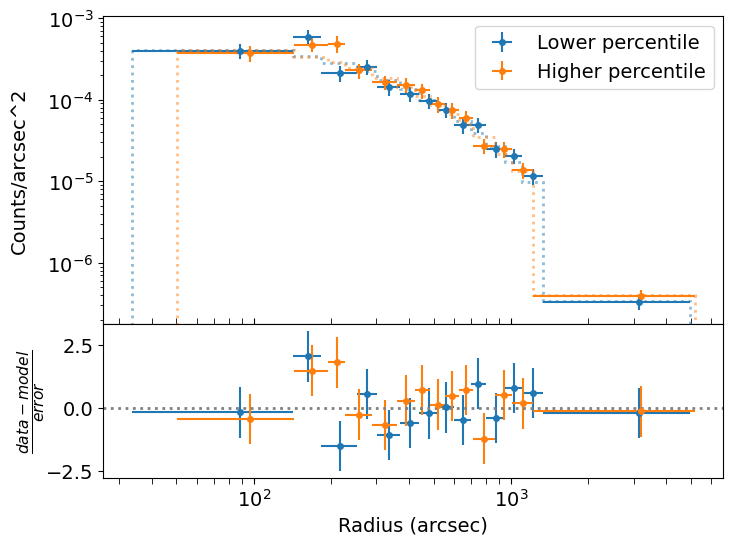

In [198]:
# To calculate the best-fitting model values, use the parameters of the best fit output
# from the fit, result.params and set output_resid=false to output a list of model y-values:
model_vals = lmf_lsq_binresid_mult(result_null.params,xdata,ydata,yerrs,model,output_resid=False)
# Now plot the data and model and residuals
legend_labels = ['Lower percentile', 'Higher percentile']
plot_spec_model_mult(xdata,ydata,yerrs,model_vals,10,200,'weighted resid',legend_labels)

Freeing up just $\rho_0$:

Let us now free up the parameter '$\rho_0$' and check if that improves the fit.

In [199]:
result_rho_free = compare_fits(params_rho_free, result_null)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 98
    # data points      = 28
    # variables        = 5
    chi-square         = 19.6227092
    reduced chi-square = 0.85316127
    Akaike info crit   = 0.04552444
    Bayesian info crit = 6.70654699
##  Warning: uncertainties could not be estimated:
    c_1:      at boundary
[[Variables]]
    rho_0_1:  5.6729e-04 (init = 0.003)
    r_c_1:    288.893971 (init = 200)
    r_t_1:    2854.36508 (init = 2000)
    c_1:      7.5717e-14 (init = 1e-06)
    rho_0_2:  5.9722e-04 (init = 0.003)
    r_c_2:    288.893971 == 'r_c_1'
    r_t_2:    2854.36508 == 'r_t_1'
    c_2:      7.5717e-14 == 'c_1'
Minimum Chi-squared for the new set of params is 19.6227 for 23 d.o.f.
The goodness of fit is:  0.6645507599265204
p-value for our delta-chi-squared:  0.5295645484872462 for 1 fewer constraints.


The p-value of 0.5296 above suggests that the result is just due to random chance and hence rho_0 is not different for the two subsamples

Let us now free up $r_c$ as well and see if that makes a difference.

In [200]:
result_r_c_free = compare_fits(params_r_c_free, result_rho_free)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 97
    # data points      = 28
    # variables        = 6
    chi-square         = 19.2507909
    reduced chi-square = 0.87503595
    Akaike info crit   = 1.50973379
    Bayesian info crit = 9.50296085
##  Warning: uncertainties could not be estimated:
    c_1:      at boundary
[[Variables]]
    rho_0_1:  5.3515e-04 (init = 0.003)
    r_c_1:    304.114312 (init = 200)
    r_t_1:    2847.42983 (init = 2000)
    c_1:      1.1102e-15 (init = 1e-06)
    rho_0_2:  6.2702e-04 (init = 0.003)
    r_c_2:    278.153761 (init = 200)
    r_t_2:    2847.42983 == 'r_t_1'
    c_2:      1.1102e-15 == 'c_1'
Minimum Chi-squared for the new set of params is 19.2508 for 22 d.o.f.
The goodness of fit is:  0.6297950664122199
p-value for our delta-chi-squared:  0.541960503880416 for 1 fewer constraints.


The p-value of 0.5420 does not suggest that the fits are different here either.<br>
Let us now try freeing up $r_t$ as well

In [201]:
result_r_t_free = compare_fits(params_r_t_free, result_r_c_free)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 110
    # data points      = 28
    # variables        = 7
    chi-square         = 19.2231844
    reduced chi-square = 0.91538974
    Akaike info crit   = 3.46955178
    Bayesian info crit = 12.7949834
##  Warning: uncertainties could not be estimated:
    c_1:      at boundary
[[Variables]]
    rho_0_1:  5.3743e-04 (init = 0.003)
    r_c_1:    300.877077 (init = 200)
    r_t_1:    2876.48980 (init = 2000)
    c_1:      8.2601e-14 (init = 1e-06)
    rho_0_2:  6.2523e-04 (init = 0.003)
    r_c_2:    280.848123 (init = 200)
    r_t_2:    2816.11806 (init = 2000)
    c_2:      8.2601e-14 == 'c_1'
Minimum Chi-squared for the new set of params is 19.2232 for 21 d.o.f.
The goodness of fit is:  0.5708254717653705
p-value for our delta-chi-squared:  0.8680374193414095 for 1 fewer constraints.


This is not a good enough p-value either (0.8680): it seems like the stellar density parameters ($\rho_0, r_t, r_c$) are not dependant on the proper motion for this cluster

<h3>General Comments and Summary of Results for Cluster NGC 2671</h3>
For this cluster, we found to a >3-$\sigma$ confidence that the parameter $r_c$ is dependant on the Gmag of stars in the cluster. The rest of the parameters were not found to be dependant on either the Gmag or absolute proper motion.

<h2>Cluster NGC 7086</h2>

In [202]:
# Add absolute proper motion
stars['abs_pm'] = np.sqrt(stars['pmRA']**2 + stars['pmDE']**2)
cluster_name = cluster_names[2]
cluster_data = calc_rad_dist(cluster_name, stars)

C:\Users\shash\AppData\Local\Temp\ipykernel_27528\1921616773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stars['abs_pm'] = np.sqrt(stars['pmRA']**2 + stars['pmDE']**2)
C:\Users\shash\AppData\Local\Temp\ipykernel_27528\2198440143.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_data_selected['rad_dist'] = 3600*np.sqrt((star_data_selected['RAdeg'] - mean_RA)**2 + (star_data_selected['DEdeg'] - mean_DE)**2)


<h3>Splitting Based on Gmag</h3>

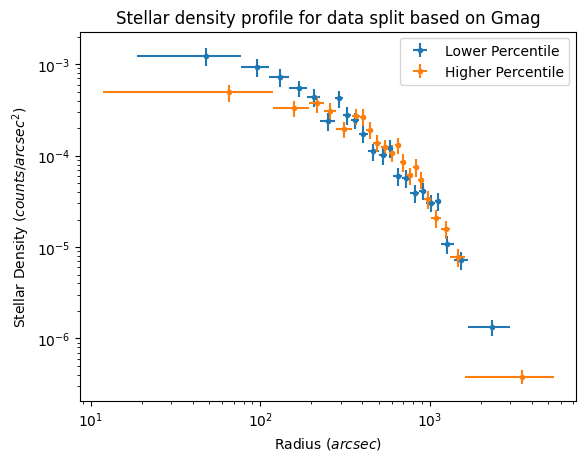

In [203]:
# Split data acc to Gmag and then plot
df_low, df_high = split_data(cluster_data, 'Gmag')
xdata, ydata, yerrs = plot_split_data(df_low, df_high, 'Gmag')

Now we set up the parameters such that the model sets all parameters for both subsamples to be equal

In [204]:
params_null = Parameters()
params_null.add_many(('rho_0_1',0.003, True, 0),('r_c_1',200, True, 0), ('r_t_1',2000, True, 0), ('c_1',1e-6, True, 0),
                ('rho_0_2',0.003,True,None,None,'rho_0_1'),('r_c_2',200,True,None,None,'r_c_1'), 
                ('r_t_2',2000,True,None,None,'r_t_1'),('c_2',1e-6, True, None, None, 'c_1'))

And then perform the fit for our null hypothesis

In [205]:
model = king_model_multi
output_resid = True
set_function = Minimizer(lmf_lsq_binresid_mult, params_null, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result_null = set_function.minimize(method = 'leastsq')
report_fit(result_null)
print("Minimum Chi-squared = "+str(result_null.chisqr.round(4))+" for "+str(result_null.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result_null.chisqr,df=result_null.nfree).round(4))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 43
    # variables        = 4
    chi-square         = 52.4965938
    reduced chi-square = 1.34606651
    Akaike info crit   = 16.5805714
    Bayesian info crit = 23.6253718
[[Variables]]
    rho_0_1:  7.2183e-04 +/- 6.6776e-05 (9.25%) (init = 0.003)
    r_c_1:    307.712316 +/- 28.0773572 (9.12%) (init = 200)
    r_t_1:    3188.75398 +/- 302.811950 (9.50%) (init = 2000)
    c_1:      6.2950e-08 +/- 1.2814e-07 (203.56%) (init = 1e-06)
    rho_0_2:  7.2183e-04 +/- 6.6776e-05 (9.25%) == 'rho_0_1'
    r_c_2:    307.712316 +/- 28.0773572 (9.12%) == 'r_c_1'
    r_t_2:    3188.75398 +/- 302.811950 (9.50%) == 'r_t_1'
    c_2:      6.2950e-08 +/- 1.2814e-07 (203.56%) == 'c_1'
[[Correlations]] (unreported correlations are < 0.100)
    C(r_t_1, c_1)     = -0.7761
    C(rho_0_1, r_c_1) = -0.7558
    C(r_c_1, r_t_1)   = -0.6349
    C(r_c_1, c_1)     = +0.3614
    C(rho_0_1, r_t_1) = +0.1019
Min

This seems like an okay fit

Let us plot the models for our subsamples

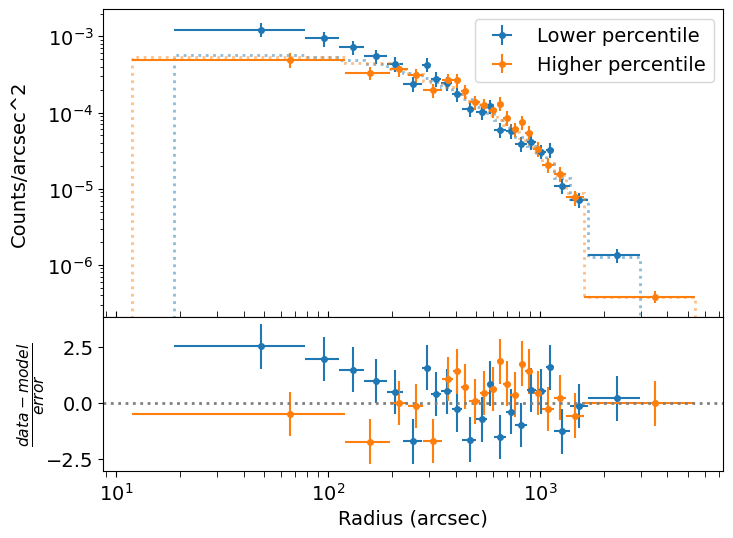

In [206]:
# To calculate the best-fitting model values, use the parameters of the best fit output
# from the fit, result.params and set output_resid=false to output a list of model y-values:
model_vals = lmf_lsq_binresid_mult(result_null.params,xdata,ydata,yerrs,model,output_resid=False)
# Now plot the data and model and residuals
legend_labels = ['Lower percentile', 'Higher percentile']
plot_spec_model_mult(xdata,ydata,yerrs,model_vals,10,200,'weighted resid',legend_labels)

There is nothing that stands out about the fit in the plot here.

Let us now free up the parameter '$\rho_0$' and check if that improves the fit.

In [207]:
result_rho_free = compare_fits(params_rho_free, result_null)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 43
    # variables        = 5
    chi-square         = 52.1438334
    reduced chi-square = 1.37220614
    Akaike info crit   = 18.2906499
    Bayesian info crit = 27.0966505
[[Variables]]
    rho_0_1:  6.9922e-04 +/- 7.4258e-05 (10.62%) (init = 0.003)
    r_c_1:    310.600884 +/- 28.7529224 (9.26%) (init = 200)
    r_t_1:    3192.89916 +/- 313.937619 (9.83%) (init = 2000)
    c_1:      5.3263e-08 +/- 1.3500e-07 (253.46%) (init = 1e-06)
    rho_0_2:  7.2911e-04 +/- 7.1054e-05 (9.75%) (init = 0.003)
    r_c_2:    310.600884 +/- 28.7529224 (9.26%) == 'r_c_1'
    r_t_2:    3192.89916 +/- 313.937619 (9.83%) == 'r_t_1'
    c_2:      5.3263e-08 +/- 1.3500e-07 (253.46%) == 'c_1'
[[Correlations]] (unreported correlations are < 0.100)
    C(r_t_1, c_1)       = -0.7896
    C(r_c_1, rho_0_2)   = -0.6986
    C(rho_0_1, rho_0_2) = +0.6875
    C(rho_0_1, r_c_1)   = -0.6762
    C(r_c_1, r_t_1)     

The p-value of 0.5526 above suggests that the result is just due to random chance and hence rho_0 is not different for the two subsamples

Let us now free up $r_c$ as well and see if that makes a difference.

In [208]:
result_r_c_free = compare_fits(params_r_c_free, result_rho_free)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 89
    # data points      = 43
    # variables        = 6
    chi-square         = 40.3440493
    reduced chi-square = 1.09037971
    Akaike info crit   = 9.25848302
    Bayesian info crit = 19.8256837
##  Warning: uncertainties could not be estimated:
    c_1:      at boundary
[[Variables]]
    rho_0_1:  0.00103825 (init = 0.003)
    r_c_1:    227.538178 (init = 200)
    r_t_1:    3315.96512 (init = 2000)
    c_1:      8.0536e-13 (init = 1e-06)
    rho_0_2:  6.1949e-04 (init = 0.003)
    r_c_2:    352.263400 (init = 200)
    r_t_2:    3315.96512 == 'r_t_1'
    c_2:      8.0536e-13 == 'c_1'
Minimum Chi-squared for the new set of params is 40.344 for 37 d.o.f.
The goodness of fit is:  0.3246842353313525
p-value for our delta-chi-squared:  0.0005923758984482341 for 1 fewer constraints.


The p-value of 0.000592 suggests that the fits are different here to a 3-$\sigma$ confidence. Hence, it is likely that $r_c$ is dependent on the Gmag of the cluster<br>
Let us now try freeing up $r_t$ as well

In [209]:
result_r_t_free = compare_fits(params_r_t_free, result_r_c_free)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 74
    # data points      = 43
    # variables        = 7
    chi-square         = 33.6030692
    reduced chi-square = 0.93341859
    Akaike info crit   = 3.39694358
    Bayesian info crit = 15.7253444
[[Variables]]
    rho_0_1:  0.00110499 +/- 1.4646e-04 (13.25%) (init = 0.003)
    r_c_1:    210.909724 +/- 21.9486667 (10.41%) (init = 200)
    r_t_1:    3472.77088 +/- 291.661811 (8.40%) (init = 2000)
    c_1:      2.5856e-07 +/- 9.9595e-08 (38.52%) (init = 1e-06)
    rho_0_2:  6.5047e-04 +/- 5.5854e-05 (8.59%) (init = 0.003)
    r_c_2:    458.066915 +/- 59.7821227 (13.05%) (init = 200)
    r_t_2:    2338.92341 +/- 262.542828 (11.22%) (init = 2000)
    c_2:      2.5856e-07 +/- 9.9595e-08 (38.52%) == 'c_1'
[[Correlations]] (unreported correlations are < 0.100)
    C(rho_0_1, r_c_1) = -0.8885
    C(r_c_2, r_t_2)   = -0.7960
    C(c_1, r_t_2)     = -0.7471
    C(r_c_1, r_t_1)   = -0.5383
    C(c_1, r_c_2)     = +0

The p val of 0.00942 is not good enough for a 3-$\sigma$ confidence level hence it seems like $r_t$ is not dependant on the Gmag of the cluster.

<h3>Splitting Based on absolute proper motion</h3>

Let us now repeat the same process but by splitting the data based on absolut proper motion

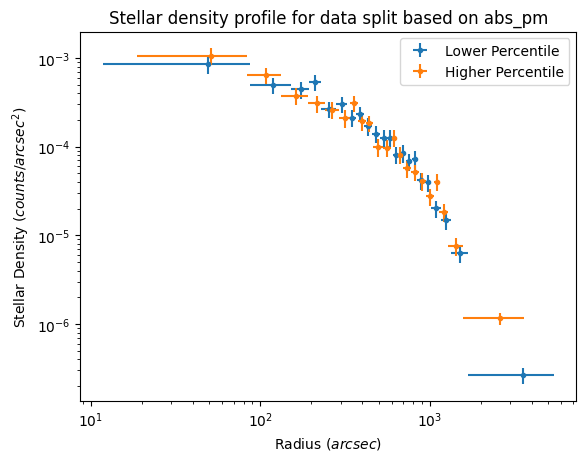

In [210]:
# Split data acc to Gmag and then plot
df_low, df_high = split_data(cluster_data, 'abs_pm')
xdata, ydata, yerrs = plot_split_data(df_low, df_high, 'abs_pm')

Null Hypothesis:

In [211]:
params_null = Parameters()
params_null.add_many(('rho_0_1',0.003, True, 0),('r_c_1',200, True, 0), ('r_t_1',2000, True, 0), ('c_1',1e-6, True, 0),
                ('rho_0_2',0.003,True,None,None,'rho_0_1'),('r_c_2',200,True,None,None,'r_c_1'), 
                ('r_t_2',2000,True,None,None,'r_t_1'),('c_2',1e-6, True, None, None, 'c_1'))

model = king_model_multi
output_resid = True
set_function = Minimizer(lmf_lsq_binresid_mult, params_null, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result_null = set_function.minimize(method = 'leastsq')
report_fit(result_null)
print("Minimum Chi-squared = "+str(result_null.chisqr)+" for "+str(result_null.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result_null.chisqr,df=result_null.nfree))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 43
    # variables        = 4
    chi-square         = 38.4881365
    reduced chi-square = 0.98687530
    Akaike info crit   = 3.23344726
    Bayesian info crit = 10.2782477
##  Warning: uncertainties could not be estimated:
    c_1:      at boundary
[[Variables]]
    rho_0_1:  7.3116e-04 (init = 0.003)
    r_c_1:    306.764833 (init = 200)
    r_t_1:    3222.58684 (init = 2000)
    c_1:      5.4783e-12 (init = 1e-06)
    rho_0_2:  7.3116e-04 == 'rho_0_1'
    r_c_2:    306.764833 == 'r_c_1'
    r_t_2:    3222.58684 == 'r_t_1'
    c_2:      5.4783e-12 == 'c_1'
Minimum Chi-squared = 38.488136538187184 for 39 d.o.f.
The goodness of fit is:  0.49304047751364277


Plot of the fit:

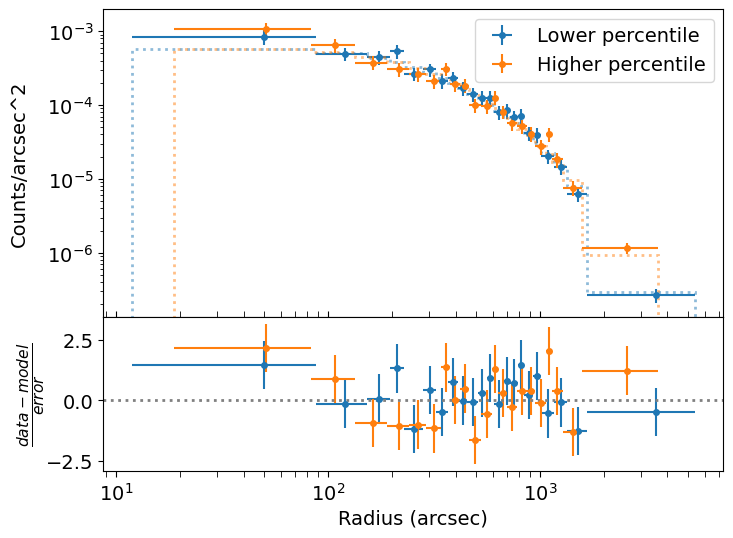

In [212]:
# To calculate the best-fitting model values, use the parameters of the best fit output
# from the fit, result.params and set output_resid=false to output a list of model y-values:
model_vals = lmf_lsq_binresid_mult(result_null.params,xdata,ydata,yerrs,model,output_resid=False)
# Now plot the data and model and residuals
legend_labels = ['Lower percentile', 'Higher percentile']
plot_spec_model_mult(xdata,ydata,yerrs,model_vals,10,200,'weighted resid',legend_labels)

Freeing up just $\rho_0$:

Let us now free up the parameter '$\rho_0$' and check if that improves the fit.

In [213]:
result_rho_free = compare_fits(params_rho_free, result_null)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 43
    # variables        = 5
    chi-square         = 38.1052881
    reduced chi-square = 1.00277074
    Akaike info crit   = 4.80357696
    Bayesian info crit = 13.6095775
##  Warning: uncertainties could not be estimated:
    c_1:      at boundary
[[Variables]]
    rho_0_1:  7.4739e-04 (init = 0.003)
    r_c_1:    307.135074 (init = 200)
    r_t_1:    3212.43610 (init = 2000)
    c_1:      5.0204e-13 (init = 1e-06)
    rho_0_2:  7.1700e-04 (init = 0.003)
    r_c_2:    307.135074 == 'r_c_1'
    r_t_2:    3212.43610 == 'r_t_1'
    c_2:      5.0204e-13 == 'c_1'
Minimum Chi-squared for the new set of params is 38.1053 for 38 d.o.f.
The goodness of fit is:  0.46469391510631675
p-value for our delta-chi-squared:  0.5360827382567638 for 1 fewer constraints.


The p-value of 0.5361 above suggests that the result is just due to random chance and hence rho_0 is not different for the two subsamples

Let us now free up $r_c$ as well and see if that makes a difference.

In [214]:
result_r_c_free = compare_fits(params_r_c_free, result_rho_free)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 43
    # variables        = 6
    chi-square         = 37.5224740
    reduced chi-square = 1.01412092
    Akaike info crit   = 6.14081757
    Bayesian info crit = 16.7080183
##  Warning: uncertainties could not be estimated:
    c_1:      at boundary
[[Variables]]
    rho_0_1:  7.8622e-04 (init = 0.003)
    r_c_1:    294.613619 (init = 200)
    r_t_1:    3216.36050 (init = 2000)
    c_1:      1.6482e-12 (init = 1e-06)
    rho_0_2:  6.7376e-04 (init = 0.003)
    r_c_2:    323.308112 (init = 200)
    r_t_2:    3216.36050 == 'r_t_1'
    c_2:      1.6482e-12 == 'c_1'
Minimum Chi-squared for the new set of params is 37.5225 for 37 d.o.f.
The goodness of fit is:  0.44513631747632465
p-value for our delta-chi-squared:  0.4452113728954742 for 1 fewer constraints.


The p-value of 0.4452 does not suggest that the fits are different here either.<br>
Let us now try freeing up $r_t$ as well

In [215]:
result_r_t_free = compare_fits(params_r_t_free, result_r_c_free)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 43
    # variables        = 7
    chi-square         = 34.1882101
    reduced chi-square = 0.94967250
    Akaike info crit   = 4.13927158
    Bayesian info crit = 16.4676724
[[Variables]]
    rho_0_1:  7.6323e-04 +/- 7.2920e-05 (9.55%) (init = 0.003)
    r_c_1:    345.771113 +/- 42.2748595 (12.23%) (init = 200)
    r_t_1:    2613.19791 +/- 318.262473 (12.18%) (init = 2000)
    c_1:      1.2914e-07 +/- 9.7566e-08 (75.55%) (init = 1e-06)
    rho_0_2:  6.9937e-04 +/- 8.0858e-05 (11.56%) (init = 0.003)
    r_c_2:    302.646725 +/- 32.1495531 (10.62%) (init = 200)
    r_t_2:    3361.67394 +/- 281.312047 (8.37%) (init = 2000)
    c_2:      1.2914e-07 +/- 9.7566e-08 (75.55%) == 'c_1'
[[Correlations]] (unreported correlations are < 0.100)
    C(rho_0_2, r_c_2) = -0.8237
    C(r_t_1, c_1)     = -0.8172
    C(r_c_1, r_t_1)   = -0.7496
    C(r_c_2, r_t_2)   = -0.6094
    C(rho_0_1, r_c_1) = -0

This is not a good enough p-value either (0.0679): it seems like the stellar density parameters ($\rho_0, r_t, r_c$) are not dependant on the proper motion for this cluster

<h3>General Comments and Summary of Results for Cluster NGC 7086</h3>
For this cluster, we found to a >3-$\sigma$ confidence that the parameter $r_c$ is dependant on the Gmag of stars in the cluster. The rest of the parameters were not found to be dependant on either the Gmag or absolute proper motion. 

<h2>Assumptions Made in Task 3</h2>
We used Wilk's theorem multiple times for this task. Wilk's theorem applies only when the alternative hypothesis is sort of a subset of the null hypothesis - in our case, this is true since since our alternatives were always the same models with the same parameters with an additional parameter being free. Wilk's theorem also needs a large dataset (or the MLEs to be normally distributed which we know is not the case from the previous task), which we have and can be seen from our model-fit plots. <br>
We  have also been careful to compare each fit with the previous alternative to ensure that any improvement in the fit is solely due to the parameter that is being freed.

<i>To note, for this task, that I have been printing the goodness of fit for all the fits but have not been commenting on all of them. For the sake of removing repetition, I have only commented on a few of them but did ensure that all the fits were okay.</i>

<h1>Task 4</h1>
<i>* Most of the code for this task was taken, and modified when needed, from the online material *</i>

In [216]:
# Select cluster to use using index
cl_index = 2
stars['abs_pm'] = np.sqrt(stars['pmRA']**2 + stars['pmDE']**2)
cluster_name = cluster_names[cl_index]
cluster_data = calc_rad_dist(cluster_name, stars)
cluster_data.columns

C:\Users\shash\AppData\Local\Temp\ipykernel_27528\907548123.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stars['abs_pm'] = np.sqrt(stars['pmRA']**2 + stars['pmDE']**2)
C:\Users\shash\AppData\Local\Temp\ipykernel_27528\2198440143.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_data_selected['rad_dist'] = 3600*np.sqrt((star_data_selected['RAdeg'] - mean_RA)**2 + (star_data_selected['DEdeg'] - mean_DE)**2)


Index(['Name', 'ID', 'GaiaDR3', 'inrt', 'Prob', 'RAdeg', 'e_RAdeg', 'DEdeg',
       'e_DEdeg', 'GLON', 'GLAT', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Plx',
       'e_Plx', 'pscol', 'e_pscol', 'PlxpmRACor', 'PlxpmDECor', 'pmRApmDECor',
       'PlxpscolCor', 'pmRApscolCor', 'pmDEpscolCor', 'Solved', 'ELAT',
       'nueff', 'RUWE', 'FidelityV1', 'FG', 'e_FG', 'FBP', 'e_FBP', 'FRP',
       'e_FRP', 'Gmag', 'BPmag', 'RPmag', 'BP-RP', 'BP-G', 'G-RP', 'RV',
       'e_RV', 'n_RV', 'o_RV', 'o_RVd', 'GRVSmag', 'e_GRVSmag', 'o_GRVSmag',
       'Vbroad', 'e_Vbroad', 'o_Vbroad', 'VarFlag', 'NSS', 'RVS', 'abs_pm',
       'rad_dist'],
      dtype='object')

<h2>Calculating the pdf of the distance to cluster</h2>
We can get the pdf for the distance to the cluster through the parallax. In order to do this, we get a weighted mean and a weighted standard error for our parallax ($\bar{\omega}$ and $s_\bar{\omega}$), which accounts for the different errors on the parallaxes. <br>
We can then propogate the standard error on our parallax using

$$
s_\bar{d} = \bar{d} * \frac{s_\bar{\omega}}{\bar{\omega}}
$$

where we have gotten $\bar{d}$ through
$$
\bar{d} = \frac{1}{\bar{\omega}}
$$

We can assume that the weighted mean parallax and hence the weighted mean distance are normally distributed due to the Central Limit Theorem (we have a large enough data set).
<!-- We can calculate the standard error for the parallax using  -->

In [217]:
def wt_mean_err(x,xerr):
    '''
    Returns the weighted mean and weighted error on the mean for input data array x with
    errors xerr
    '''
    weights = xerr**(-2)
    sum_weights = np.sum(weights)
    wtmean = np.sum(weights*x)/sum_weights
    wterr = sum_weights**(-0.5)
    return wtmean, wterr

plx_wt_mean, plx_wt_err = wt_mean_err(cluster_data['Plx'], cluster_data['e_Plx'])

# Now we can propogate the error:
d_wt_mean = 1/plx_wt_mean
d_wt_err = d_wt_mean * plx_wt_err/plx_wt_mean

# Convert to m
d_wt_mean = u.pc.to(u.m, d_wt_mean * 1e3)
d_wt_err = u.pc.to(u.m, d_wt_err * 1e3)
print(f'The weighted mean distance to the cluster is {d_wt_mean:.4e} m, with a weighted error of \u00B1{d_wt_err:.2e} m')

The weighted mean distance to the cluster is 5.1658e+19 m, with a weighted error of ±6.85e+16 m


<h2>Mean Squared Velocity Disperion</h2>
The velocity dispersion is defined as:
$$
X_i = (pm_i^2 - \overline{pm})^2
$$
If we simplify the expression for E[X], we will see that it us just $\sigma_pm^2$, but the expression for V[X] is more complicated.<br>
We can take the expectation value and variance of this, since they are just arrays, and calculate them for our cluster.
We define a function below to do this

In [77]:
def calc_mean_squared_vel_disp(df):
    """
    Calculates the mean and the variance of the squared velocity distribution. This can be used to define a normal distribution.
    """
    mean_pm = np.mean(df['abs_pm'])
    var_pm = np.mean((df['abs_pm'] - mean_pm)**2)
    X = (df['abs_pm'] - mean_pm)**2
    # print(X.mean())
    mean, var = X.mean(), X.var()

    return mean, var

mean_sqrd_vel_disp_calc,var_sqrd_vel_disp_calc = calc_mean_squared_vel_disp(cluster_data)
err_sqrd_vel_disp = var_sqrd_vel_disp_calc / np.sqrt(len(cluster_data['abs_pm']))
print(f'The mean squared velocity dispersion is {mean_sqrd_vel_disp_calc:.4e} m, with an error of \u00B1{err_sqrd_vel_disp:.2e} m')

The mean squared velocity dispersion is 2.0772e-02 m, with an error of ±4.24e-05 m


Since we want to work using values of mass and the squared velocity dispersion, we need to redefine our king model to be able to work with this

In [87]:
def king_model_MCMC(r, params, r_arr = False):
    """
    Params: rho_0, r_t, M, mean_sqrd_vel_disp. 
    r_t and mean_sqrd_vel_disp must be in mas and (mas/yr)^2 respectively. 
    rho_0 must be in counts/arcsec^2
    r must be in arcsec
    r can be an array or a single value (c is not included in the model as for our clusters it seems to essentially be 0, hence we just fix it)
    """
    
    param_vals = params.valuesdict()
    # We first need to calculate r_c using our equation from the Virial Theorem
    c = 1e-7
    as_to_rad = 4.84814e-6
    G = 6.6e-11
    # For the velocity dispersion, we need to convert (mas/yr)**2 to 
    factor = ((4.8481e-9 * param_vals['d']) / (365 * 24 * 60**2))**2
    param_vals['mean_sqrd_vel_disp'] = param_vals['mean_sqrd_vel_disp'] * factor    
    
    r_c = (2 * G * param_vals['M']) / (3 * param_vals['mean_sqrd_vel_disp']) # Calc r_c using eqn (in metres)
    # print('r_c (m):', r_c)
    r_c = r_c * 1/(as_to_rad * param_vals['d']) # we convert r_c into arcsec
    # print('r_c (arcsec):', r_c)
    if not r_arr:
        if r>param_vals['r_t']:
            return c # Returns 0 instead of c (we can fix it at whatever value works)
        if r<=param_vals['r_t']:
            rho = param_vals['rho_0'] * ((1 / np.sqrt(1 + (r/r_c)**2)) - (1 / np.sqrt(1 + (param_vals['r_t']/r_c)**2)))**2 + c
            return rho

    if r_arr:
        r_below = r[r<=param_vals['r_t']]
        r_above = r[r>param_vals['r_t']]
        rho_below = param_vals['rho_0'] * ((1 / np.sqrt(1 + (r_below/r_c)**2)) - (1 / np.sqrt(1 + (param_vals['r_t']/r_c)**2)))**2 + c
        rho_above = r_above * 0 + c
        rho = np.append(rho_below, rho_above)
        return rho
    return rho

Checking whether our model gives an output using some dummy values

Text(0.5, 1.0, 'Testing Re-defined King Model')

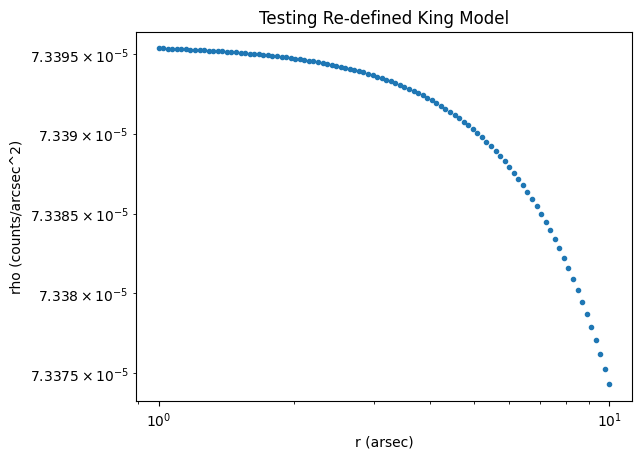

In [88]:
params_new_model_test = Parameters()
params_new_model_test.add_many(('rho_0', 8e-5, True, 0), ('r_t', 1.4e4, True, 0), ('M', 1e30, True, 0), ('mean_sqrd_vel_disp', 1e-5, True, 0), ('d', 4e19, True, 0))
r = np.logspace(0, 1, 100)
y = king_model_MCMC(r, params_new_model_test, r_arr=True)
plt.plot(r, y, '.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r (arsec)')
plt.ylabel('rho (counts/arcsec^2)')
plt.title('Testing Re-defined King Model')

<h2>Getting an Initial Fit for Walkers</h2> 
Let us try to approximately fit our parameters to our data.<br>
Getting the data first

In [93]:
density, r_edges, err_counts, bin_widths, r_counts = stellar_density(cluster_data, ret_counts=True)

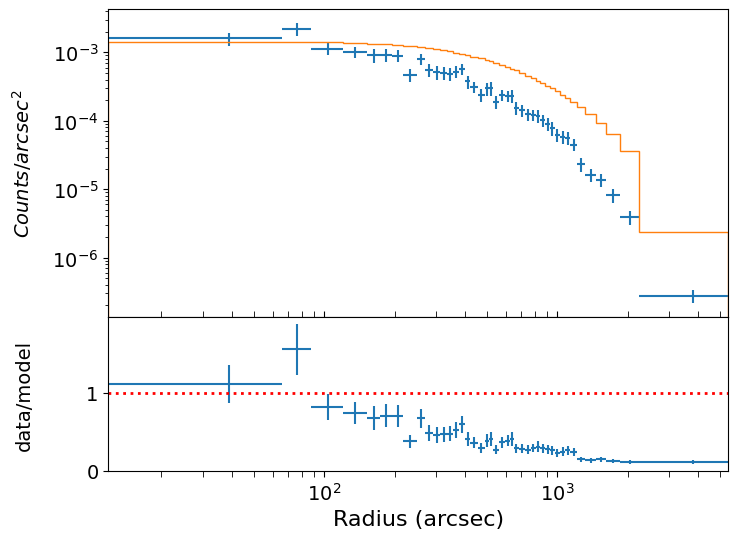

In [94]:
params_MCMC = Parameters()
params_MCMC.add_many(('rho_0', 2e-3, True, 0), ('r_t', .4e4, True, 0), ('M', .4e30, True, 0), ('mean_sqrd_vel_disp', .4e-5, True, 0), ('d', 4e19, True, 0))

model_vals = lmf_lsq_binresid_to_poisll(params_MCMC,xdata,ydata,yerrs,model,output_resid=False)
plot_spec_model(r_edges,density,err_counts,model_vals[0])

This isnt a great fit but let's hope our MCMC code can take it from here.

<h2>MCMC Stuff</h2>

In [95]:
best_par_list = []
for par in ['rho_0','r_t','M', 'mean_sqrd_vel_disp', 'd']:
    best_par_list.append(params_MCMC[par].value)
best_par=np.array(best_par_list) # needs to be an array so we can use it for calculations
ndim, nwalkers = 5, 100  # The number of parameters and the number of walkers (we follow the 
# emcee example and use 100)
output_ll=True
pos = [best_par + 0.01*best_par*sps.norm.rvs(size=ndim) for i in range(nwalkers)]  # we spread the 
# walkers around the MLEs with a standard deviation equal to 1 per cent of the MLE value

In [96]:
def model_bin(xbins, model, params):
    '''
    General function for integrating the input model over bins defined by contiguous (no gaps) 
        bin edges, xbins.
       Inputs:
           xbins - x bin edges.
           model, params - the model name and associated Parameters object.
       Outputs:
           ymod - calculated counts-density model values for y-axis.
    '''
    i = 0
    ymod = np.zeros(len(xbins)-1)
    for i, xval in enumerate(xbins[:-1]):
        # We need to integrate over the area of each bin rather than the radius
        ymod[i], ymoderr = spint.quad(lambda x: 2 * np.pi * x * model(x, params),xbins[i],xbins[i+1]) 
        ymod[i] = ymod[i]/(np.pi * (xbins[i+1]**2-xbins[i]**2))  # we now divide by the bin area to match the counts density
        # units of our data
    return ymod


def lmf_poissll_emcee(params,xdata,ydata,model,prior_model,output_ll=True):
    '''
    lmfit-style objective function to calculate and return total Poisson log-likelihood or model 
        y-values for binned data where the xdata are the contiguous (i.e. no gaps) input bin edges and 
        ydata are the counts (not count densities) per bin.
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y counts density array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (total -ve 
                        log-likelihood) is required output, otherwise a list of model y-value arrays 
                        (corresponding to the input x-data list) is returned.
        Output: if output_resid==True, returns the total negative log-likelihood. If output_resid==False, 
                returns a list of y-model counts density arrays (one per input x-array)'''
    if output_ll == True:
        poissll = 0
        for i, xvals in enumerate(xdata):  # loop through each input dataset to sum negative log-likelihood
                # We can re-use our model binning function here, but the model then needs to be converted into 
                # counts units from counts density, by multiplying by the bin area
                ymodel = model_bin(xdata[i],model,params)*(xdata[i][1:]**2 - xdata[i][:-1]**2) * np.pi
                # Then obtain negative Poisson log-likelihood for data (in counts units) vs the model 
                poissll = poissll + (-1*LogLikelihood_Pois(ymodel,ydata[i]))
        poissll_prior = poissll + prior_model(params)     
        if not np.isfinite(poissll_prior):
            return -np.inf
        else:
            return poissll_prior
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin(xdata[i],model,params))
        return ymodel


def LogLikelihood_Pois(model_counts, counts): 
    '''Calculate the negative Poisson log-likelihood for a model vs counts data. 
       Inputs:
           model_counts - array of predicted model counts per bin
           counts - data: observed counts per bin.
        Outputs: the negative Poisson log-likelihood'''
    pd = sps.poisson(model_counts) #we define our Poisson distribution
    return -1*np.sum(pd.logpmf(counts))


def king_model_emcee(r, pars, r_arr = False):
    '''
    Power-law function with an exponential cut-off.
       Inputs:
           x - input x value(s) (can be list or single value).
           pars - parameters, list of PL normalisation (at x = 1) and power-law index.'''
    (rho_0, r_t, M, mean_sqrd_vel_disp, d) = pars
    r = np.array(r)
     # We first need to calculate r_c using our equation from the Virial Theorem
    as_to_rad = 4.84814e-6
    G = 6.6e-11
    # For the velocity dispersion, we need to convert (mas/yr)**2 to 
    factor = ((4.8481e-9 * d) / (365 * 24 * 60**2))**2
    mean_sqrd_vel_disp = mean_sqrd_vel_disp * factor 

    r_c = (2 * G * M) / (3 * mean_sqrd_vel_disp) # Calc r_c using eqn (in metres)
    r_c = r_c * 1/(as_to_rad * d) # we convert r_c into arcsec

    # Now calculate density - we need to handle arrays/lists differenly from single values
    if not r_arr:
        if r>r_t:
            return 1e-5 # Returns 0 instead of c (we can fix it at whatever value works)
        if r<=r_t:
            rho = rho_0 * ((1 / np.sqrt(1 + (r/r_c)**2)) - (1 / np.sqrt(1 + (r_t/r_c)**2)))**2
            return rho

    if r_arr:
        r_below = r[r<=r_t]
        r_above = r[r>r_t]
        rho_below = rho_0 * ((1 / np.sqrt(1 + (r_below/r_c)**2)) - (1 / np.sqrt(1 + (r_t/r_c)**2)))**2
        rho_above = r_above * 0 + 1e-5
        rho = np.append(rho_below, rho_above)
        return rho
    
def king_logprior(pars):
    '''
    returns the combined log-prior for the given input pars. Here we assume a uniform
    within specified limits, and zero probability (-ve infinity log-p) otherwise.
    '''
    (rho_0, r_t, M, mean_sqrd_vel_disp, d) = pars
    if ((rho_0 <= 0) | (r_t < 0) | (mean_sqrd_vel_disp <= 0) | (d <= 0)):
        return -np.inf
    else:
        logL_sqrd_vel_disp = -(mean_sqrd_vel_disp - mean_sqrd_vel_disp_calc)**2 / (2 * var_sqrd_vel_disp_calc**2)
        logL_d = -(d - d_wt_mean)**2/(2 * d_wt_err**2) # Approximations 
        return logL_sqrd_vel_disp + logL_d

In [100]:
from multiprocess import Pool

model = king_model_emcee
prior_model = king_logprior
sampler = emcee.EnsembleSampler(nwalkers, ndim, lmf_poissll_emcee, args=(xdata,ydata,model,prior_model,output_ll))
sampler.run_mcmc(pos, 1000)

np.save('Test1_noPool_2',sampler.chain)

C:\Users\shash\AppData\Local\Temp\ipykernel_27528\483381604.py:15: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  ymod[i], ymoderr = spint.quad(lambda x: 2 * np.pi * x * model(x, params),xbins[i],xbins[i+1])


I am ignoring the above warnings (since idk what is causing them and it does not seeme to crash the code - I am guessing it has something to do with the 0 counts predictions for poisson distributions though)<br>
Let us plot our walkers and check if they look okay

C:\Users\shash\AppData\Local\Temp\ipykernel_27528\2968999035.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


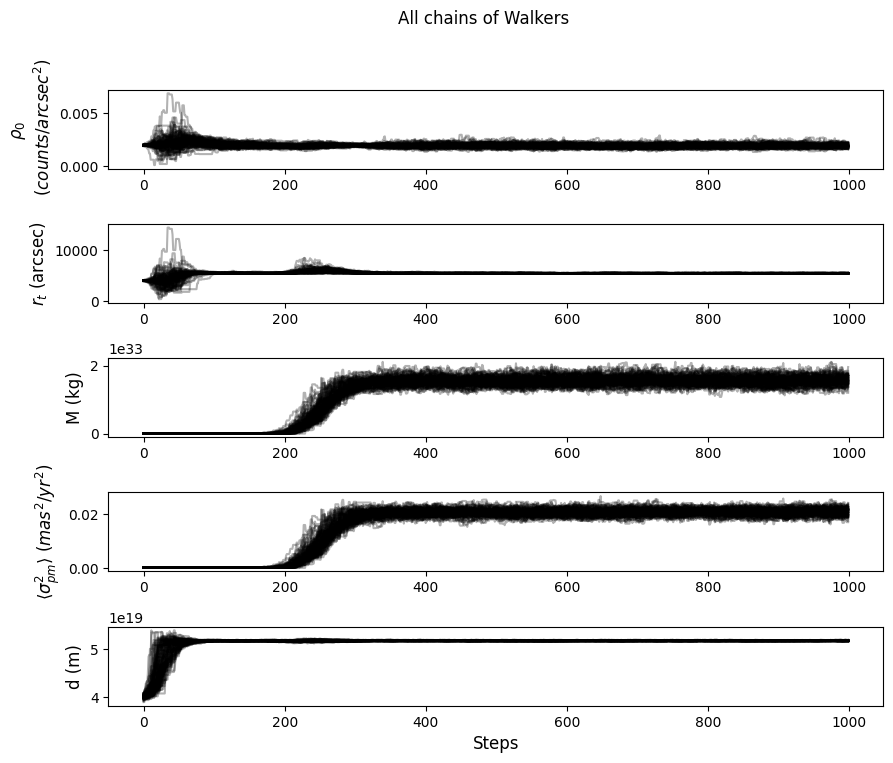

In [237]:
labels_list = [f'$\\rho_0$ \n ($counts/arcsec^2$)',r'$r_t$ (arcsec)', 'M (kg)',r'$\langle\sigma^2_{pm}\rangle$ ($mas^2/yr^2$)', 'd (m)'] # labels for our plots

nsteps = 1000  # How many steps to plot. We plot fewer steps since we include all walkers.
fig = plt.figure(figsize=(10,8))
fig.clf()
for j in range(ndim):
    ax = fig.add_subplot(ndim,1,j+1)
    for k in range(nwalkers):
        ax.plot(sampler.chain[k,:nsteps,j],color='black',alpha = 0.3)
    ax.set_ylabel(labels_list[j], fontsize = 12)
fig.subplots_adjust(wspace=0.5,hspace=.7)
plt.xlabel('Steps', fontsize = 12)
fig.suptitle('All chains of Walkers')
plt.savefig('allchains_kingmodel.png')
fig.show()

It seems like all of them have converged to sample the distribution - we can even notice the burn in time. $\rho_0$ and $r_t$ show extended peaks toward the beginning but its okay since they eventually get back to the distribution - perhaps this hints at some feature of the distribution?<br>
Let us look at just one of the walkers now

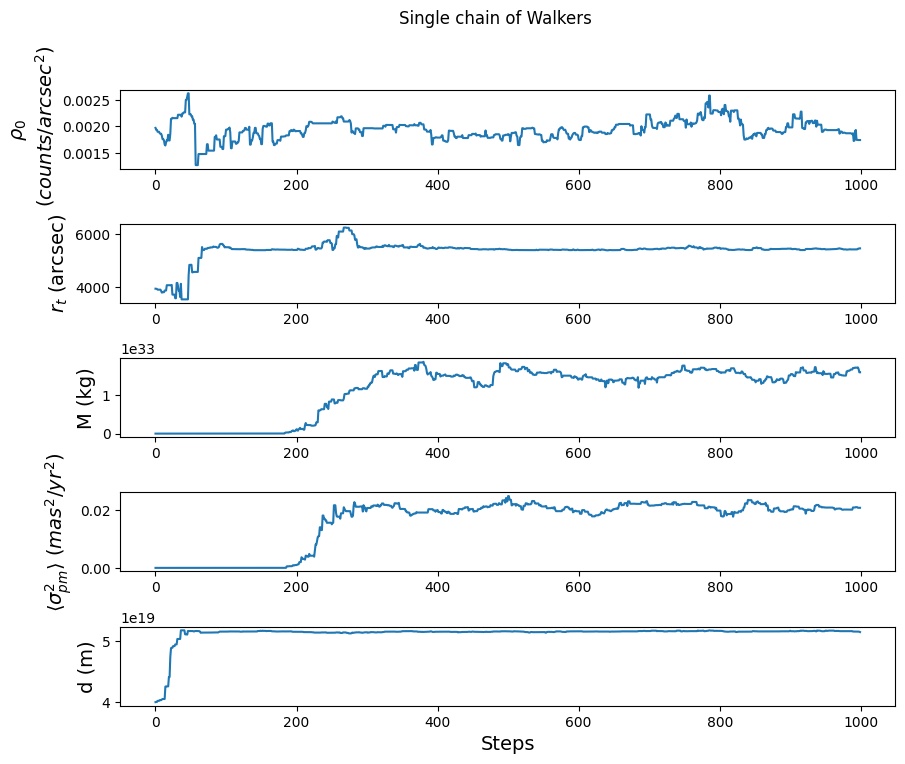

In [238]:
plt.close()
nsteps = 1000  # How many steps to plot
rng = np.random.default_rng()  # Set up a random number generator to select a random walker
fig = plt.figure(figsize=(10,8))
for j in range(ndim):
    ax = fig.add_subplot(ndim,1,j+1)
    ax.plot(sampler.chain[rng.integers(nwalkers),:nsteps,j]) # plot the chain for a random walker
    ax.set_ylabel(labels_list[j], fontsize = 14)
fig.subplots_adjust(wspace=0.5,hspace=1)
plt.xlabel('Steps', fontsize = 14)
fig.suptitle('Single chain of Walkers')
fig.subplots_adjust(wspace=0.5,hspace=.7)
plt.savefig('singlechain_kingmodel.png')
# fig.show()

We can notice the odd peak here in the $r_t$ again, but it does seem to go back to the true distribution eventually. We can very clearly see the burn in time here.<br>
Let us look at the power spectrum of our walkers to ensure that we are actually sampling the distribution independantly

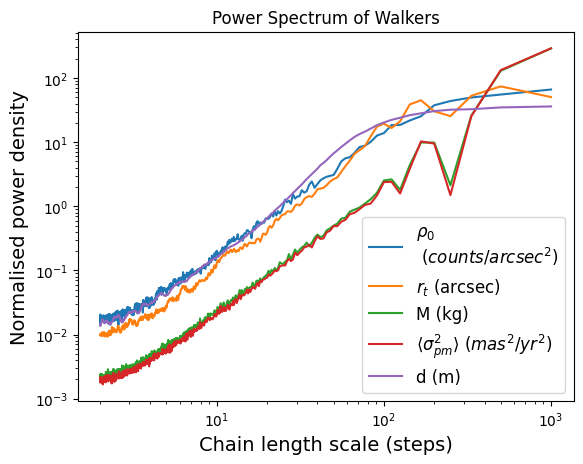

In [239]:
import scipy

def plot_chains_powspec(chain_in,labels): 
    powspec = np.sum(np.abs(scipy.fft.fft(chain_in,axis=1))**2,axis=0)
    freq = scipy.fft.fftfreq(len(chain_in[0,:,0]))
    plt.figure()
    for i in range(ndim):
        plt.plot(1/freq[1:len(freq)//2],
                 powspec[1:len(freq)//2,i]/np.mean(powspec[1:len(freq)//2,i]),label=labels[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Chain length scale (steps)', fontsize = 14)    
    plt.ylabel(r'Normalised power density', fontsize = 14)
    plt.legend(fontsize=12)
    plt.title('Power Spectrum of Walkers')
    plt.savefig('allchains_powspec_kingmodel.png')
    plt.show()
    return

plot_chains_powspec(sampler.chain,labels_list)

We can see that the slope starts flattening out around 200-300 steps into the chain, suggesting that from then on the the distribution is being sampled completely independantly. The spectrum for d and <$\sigma_pm^2$> is less convincing though! We should probably run it for 10,000 steps but I doubt my computer can handle it in time, especially since using Pool seems to crash it.

Let us now finally plot our results

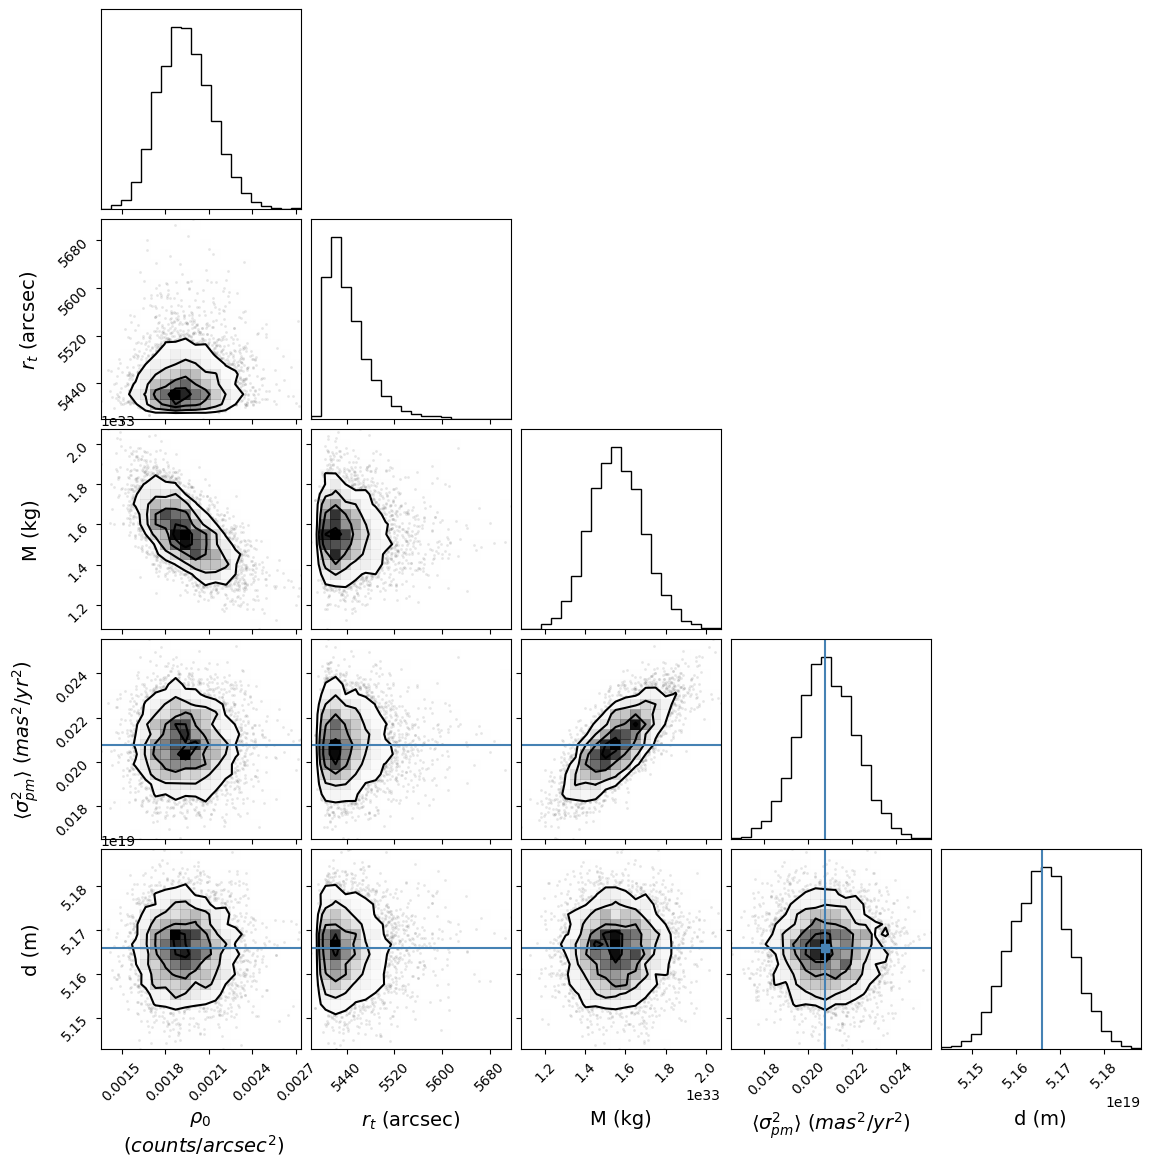

In [240]:
# Plot a corner plot using thin=10 to reduce the density for visual appearance
flat_samples = sampler.get_chain(discard=500, thin=10, flat=True) 
fig = corner.corner(flat_samples, labels=labels_list, label_kwargs={"fontsize": 14}, truths=[None, None, None, mean_sqrd_vel_disp_calc, d_wt_mean])
plt.savefig('ep12_corner_plexpcut_1000cts.png')
plt.show()

The blue lines  on the plot indicate our calculated value of d (through the parallaxes) and mean squared velocity dispersion (through the proper motions). As we can see, they seem to have barely been changed by MCMC code - this is likely due to the very strong prior we had on them compared to the other parameters. <br><br>
It is also interesting to note that $r_t$ seems to have a very skewed distribution - we also saw this in our previous task and commented on it; this likely means that higher values of $r_t$ are much more compatible (or 'correct') than lower values.

Let us look at the 1-$\sigma$ errors on our results

In [241]:
flat_samples_full = sampler.get_chain(discard=500, flat=True)
print("Median and 1-sigma errors")
for i in range(ndim):
    mcmc = np.percentile(flat_samples_full[:, i], [15.85, 50, 84.15])
    q = np.diff(mcmc)
    txt = "{3} = {0:.4e} -{1:.4e}/+ {2:.4e}" # This formatting rounds to 3 decimal places.
    txt = txt.format(mcmc[1], q[0], q[1],  [r'rho_0 (counts/arcsec^2)','r_t(arcsec)', 'M (kg)','mean_sqrd_vel_disp (mas^2/yr^2', 'd (m)'][i])
    print(txt)

Median and 1-sigma errors
rho_0 (counts/arcsec^2) = 1.9310e-03 -1.7433e-04/+ 1.9286e-04
r_t(arcsec) = 5.4334e+03 -2.2961e+01/+ 4.2296e+01
M (kg) = 1.5523e+33 -1.3007e+32/+ 1.3700e+32
mean_sqrd_vel_disp (mas^2/yr^2 = 2.0812e-02 -1.2645e-03/+ 1.3376e-03
d (m) = 5.1657e+19 -7.1669e+16/+ 6.6526e+16


We have obtained a Mass of $1.552*10^{33}$ kg with 1-$\sigma$ errors ( $-1.30*10^{32}/+1.37*10^{32}$) kg

<h2>Assumptions Made in Task 4</h2>
While calculating the Log-likelihoods, I used the expression $\frac{(\theta - \hat{\theta})^2}{2\sigma^2}$. This is exact when the distribution is normal, which is what we have assumed our prior distributions to be for both the squared velocity dispersion and the distance. <br>
We have also calculated the weighted mean rather than just the mean for the parallaxes (and hence the distance), which gives a value closer to the true distance. We have also assumed, since we used error propogation, that the function that we use to calculate the distance (1/$\omega$) can be approximated linearly around the mean, which is, again, a fair assumption.<br>
For the MCMC code to sample the distribution properly, we need it to sample the distribution independantly. For this to happen, we want the walkers to have path lengths of greater then the auto-correlation time. To get a robust check of this, we used the power spectrum of the walkers, where the slope indidcates whether or not the sampling resembles a random walk. As we saw in the power spectrum, it had seemed to flatten out, which suggests that we our chain lengths are beyond the autocorrelation timescale/lengthscale.